In [16]:
# 1. 导入依赖和加载数据
import json
import pandas as pd
import random
import time
import requests
import os
import re
from typing import Dict, List, Any
from datetime import datetime

# 加载Quick80数据集
def load_dataset(dataset_path: str = "quick80_dataset.json") -> List[Dict]:
    """加载Taboo数据集"""
    with open(dataset_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# 加载数据集
print("📚 正在加载Quick80数据集...")
dataset = load_dataset()
print(f"✅ 数据集加载完成，共{len(dataset)}条记录")

# 显示数据集样本
print("\n📋 数据集样本:")
sample = random.choice(dataset)
print(f"   目标词: {sample['target']}")
print(f"   类别: {sample.get('category', 'unknown')}")
print(f"   禁用词: {sample['taboo']}")
print(f"   词义数: {len(sample.get('senses', []))}")

# 设置随机种子
random.seed(240)
print("\n🎲 随机种子已设置为240，确保实验可复现")


📚 正在加载Quick80数据集...
✅ 数据集加载完成，共80条记录

📋 数据集样本:
   目标词: architecture
   类别: philosophy
   禁用词: ['edifice', 'product', 'building', 'work', 'architectural']
   词义数: 4

🎲 随机种子已设置为240，确保实验可复现


In [17]:
# 2. API客户端配置
def load_api_keys(keys_path: str = "api_keys.json") -> Dict[str, str]:
    """加载API密钥"""
    with open(keys_path, 'r', encoding='utf-8') as f:
        return json.load(f)

class OpenRouterClient:
    """OpenRouter API客户端"""
    def __init__(self, api_key: str):
        self.api_key = api_key
        self.base_url = "https://openrouter.ai/api/v1/chat/completions"
        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json"
        }
    
    def call_model(self, model: str, messages: List[Dict[str, str]], temperature: float = 0.3) -> str:
        """调用模型API"""
        payload = {
            "model": model,
            "messages": messages,
            "temperature": temperature,
            "max_tokens": 2000
        }
        response = requests.post(self.base_url, headers=self.headers, json=payload, timeout=30)
        response.raise_for_status()
        result = response.json()
        content = result['choices'][0]['message']['content'].strip()
        
        # 防止乱码：只保留ASCII可打印字符
        content = re.sub(r'[^\x20-\x7E]', '', content)
        return content

# 初始化API客户端
try:
    api_keys = load_api_keys()
    client = OpenRouterClient(api_keys["OPENROUTER_API_KEY"])
    print("✅ API客户端初始化成功")
except Exception as e:
    print(f"❌ API客户端初始化失败: {e}")
    client = None


✅ API客户端初始化成功


In [18]:
# 3. 实验参数配置
# 定义目标模型 - 只使用DeepSeek和Gemini
QUANTITATIVE_MODELS = [
    "deepseek/deepseek-chat-v3-0324", 
    "google/gemini-2.5-flash"
]

# 实验参数设置
TEMPERATURE_VALUES = [0.1, 0.3, 0.7]  # 温度参数
TABOO_COUNTS = [1, 3, 5]  # 禁忌词数量  
HINT_WORD_COUNTS = [1, 5, 10]  # Hinter提示长度
DATASET_SIZE = 80  # 数据集大小

print("📊 实验配置:")
print(f"   数据集大小: {DATASET_SIZE} 词汇")
print(f"   目标模型: {len(QUANTITATIVE_MODELS)} 个")
for i, model in enumerate(QUANTITATIVE_MODELS, 1):
    model_name = model.split('/')[-1] 
    print(f"      {i}. {model_name}")
print(f"   温度参数: {TEMPERATURE_VALUES}")
print(f"   禁忌词数量: {TABOO_COUNTS}")
print(f"   Hinter提示长度: {HINT_WORD_COUNTS} (单词个数)")

# 计算实验规模
total_combinations = len(QUANTITATIVE_MODELS) ** 2  # 2x2 = 4个组合
total_data_variants = DATASET_SIZE * len(TABOO_COUNTS)  # 80 x 3 = 240个
total_experiments = total_combinations * len(TEMPERATURE_VALUES) * len(HINT_WORD_COUNTS) * total_data_variants
# 4 x 3 x 3 x 240 = 8,640个实验

print(f"\n🎮 实验规模:")
print(f"   模型组合: {total_combinations} 个 (2×2)")
print(f"   温度参数: {len(TEMPERATURE_VALUES)} 个")
print(f"   提示长度: {len(HINT_WORD_COUNTS)} 个")
print(f"   数据变体: {total_data_variants} 个 (80词汇×3禁忌词变体)")
print(f"   **总实验数: {total_experiments:,} 个**")
print(f"   **预计耗时: {total_experiments * 0.5 / 3600:.1f} 小时**")

print(f"\n✅ 配置完成")


📊 实验配置:
   数据集大小: 80 词汇
   目标模型: 2 个
      1. deepseek-chat-v3-0324
      2. gemini-2.5-flash
   温度参数: [0.1, 0.3, 0.7]
   禁忌词数量: [1, 3, 5]
   Hinter提示长度: [1, 5, 10] (单词个数)

🎮 实验规模:
   模型组合: 4 个 (2×2)
   温度参数: 3 个
   提示长度: 3 个
   数据变体: 240 个 (80词汇×3禁忌词变体)
   **总实验数: 8,640 个**
   **预计耗时: 1.2 小时**

✅ 配置完成


In [19]:
# 4. 核心工具函数 (参考base_test框架)
def safe_text_cleanup(text: str, max_length: int = 200) -> str:
    """安全清理文本，防止乱码和超长内容"""
    if not text:
        return ""
    cleaned = re.sub(r'[^\x20-\x7E\n\r\t]', '', str(text))
    if len(cleaned) > max_length:
        cleaned = cleaned[:max_length] + "..."
    return cleaned

def robust_api_call(client, model: str, base_prompt: str, expected_prefix: str, 
                   temperature: float = 0.3, max_retries: int = 3):
    """健壮的API调用，包含重试机制和格式验证"""
    failed_outputs = []
    
    for attempt in range(1, max_retries + 1):
        try:
            if attempt == 1:
                prompt = base_prompt
            else:
                prev_output = failed_outputs[-1] if failed_outputs else "Unknown"
                format_reminder = f"""

⚠️ FORMAT ERROR DETECTED ⚠️
Your previous response was: "{prev_output}"

REQUIRED FORMAT:
- You MUST start with exactly '{expected_prefix}' (including square brackets)
- Do NOT add any text before {expected_prefix}

Try again with the exact format:"""
                prompt = base_prompt + format_reminder
            
            response = client.call_model(model, [{"role": "user", "content": prompt}], temperature)
            
            if response.strip().upper().startswith(expected_prefix.upper()):
                return {
                    'success': True,
                    'response': response,
                    'attempts': attempt,
                    'error': None,
                    'failed_outputs': failed_outputs
                }
            else:
                safe_response = safe_text_cleanup(response, max_length=150)
                failed_outputs.append(safe_response)
                
                if attempt == max_retries:
                    all_failed = " | ".join(failed_outputs)
                    return {
                        'success': False,
                        'response': f"FORMAT_ERROR_EXCEEDED: {safe_response}",
                        'attempts': attempt,
                        'error': f"Failed after {max_retries} attempts. Expected '{expected_prefix}'. All failed outputs: {all_failed}",
                        'failed_outputs': failed_outputs
                    }
                time.sleep(0.5)
                
        except Exception as e:
            safe_error = safe_text_cleanup(str(e), max_length=150)
            error_msg = f"API error (attempt {attempt}/{max_retries}): {safe_error}"
            
            if attempt == max_retries:
                return {
                    'success': False,
                    'response': None,
                    'attempts': attempt,
                    'error': error_msg,
                    'failed_outputs': failed_outputs
                }
            time.sleep(1.0)
    
    return {
        'success': False,
        'response': None,
        'attempts': max_retries,
        'error': "Max retries exceeded",
        'failed_outputs': failed_outputs
    }

def extract_clue_text(response: str) -> str:
    """从响应中提取线索文本"""
    if response.startswith("FORMAT_ERROR_EXCEEDED"):
        return "FORMAT_ERROR"
    
    if '[CLUE]' in response.upper():
        match = re.search(r'\[CLUE\]\s*(.+)', response, re.IGNORECASE | re.DOTALL)
        if match:
            return match.group(1).strip()
    
    if 'Clue:' in response:
        return response.split('Clue:')[1].strip()
    
    return "INVALID_FORMAT"

def extract_guess_word(response: str) -> str:
    """从响应中提取猜测词"""
    if response.startswith("FORMAT_ERROR_EXCEEDED"):
        return "FORMAT_ERROR"
    
    if '[GUESS]' in response.upper():
        match = re.search(r'\[GUESS\]\s*(.+)', response, re.IGNORECASE)
        if match:
            guess_part = match.group(1).strip()
            guess = guess_part.split()[0] if guess_part.split() else ""
            return guess.strip('.,!?;:"\'()[]{}')
    
    if 'Guess:' in response:
        guess_part = response.split('Guess:')[1].strip()
        guess = guess_part.split()[0] if guess_part.split() else ""
        return guess.strip('.,!?;:"\'()[]{}')
    
    return "INVALID_FORMAT"

def check_taboo_violation(hint, taboo_words):
    """检查hinter的线索是否违反了禁用词规则"""
    hint_lower = hint.lower()
    
    for taboo in taboo_words:
        taboo_lower = taboo.lower()
        # 检查完整单词匹配
        if re.search(r'\b' + re.escape(taboo_lower) + r'\b', hint_lower):
            return True
        # 检查部分拼写（至少3个字符）
        if len(taboo_lower) >= 3 and taboo_lower in hint_lower:
            return True
    
    return False

def prepare_experiment_dataset(dataset, dataset_size, taboo_counts):
    """准备实验数据集，创建不同禁忌词数量的变体"""
    # 随机选择指定数量的词汇
    sample_words = random.sample(dataset, min(dataset_size, len(dataset)))
    experiment_dataset = []
    
    for word_data in sample_words:
        original_taboo = word_data['taboo']
        
        for count in taboo_counts:
            # 选择前N个禁忌词
            selected_taboo = original_taboo[:count] if count <= len(original_taboo) else original_taboo
            
            variant = {
                'target': word_data['target'],
                'category': word_data.get('category', 'unknown'),
                'taboo': selected_taboo,
                'taboo_count': len(selected_taboo),
                'experiment_id': f"{word_data['target']}_{len(selected_taboo)}taboo"
            }
            experiment_dataset.append(variant)
    
    return experiment_dataset

# 准备实验数据集
print("📊 准备实验数据集...")
random.seed(240)  # 确保可复现
experiment_dataset = prepare_experiment_dataset(dataset, DATASET_SIZE, TABOO_COUNTS)

print(f"✅ 数据集准备完成")
print(f"   词汇数量: {DATASET_SIZE} 个")
print(f"   数据变体: {len(experiment_dataset)} 个")

# 显示分布
taboo_distribution = {}
for item in experiment_dataset:
    count = item['taboo_count']
    taboo_distribution[count] = taboo_distribution.get(count, 0) + 1

print(f"   禁忌词分布: {taboo_distribution}")

print("✅ 增强核心工具函数已定义 (包含健壮API调用和格式验证)")


📊 准备实验数据集...
✅ 数据集准备完成
   词汇数量: 80 个
   数据变体: 240 个
   禁忌词分布: {1: 80, 3: 80, 5: 80}
✅ 增强核心工具函数已定义 (包含健壮API调用和格式验证)


In [20]:
# 5. 增强游戏逻辑 (参考base_test的健壮框架)
def enhanced_quantitative_taboo_game(client, hinter_model, guesser_model, target_word, taboo_words, 
                                    temperature=0.3, hint_word_count=5, max_turns=5):
    """增强版定量分析Taboo游戏，包含完整的错误处理和统计追踪"""
    
    conversation_history = []
    taboo_list = ', '.join(taboo_words)
    
    # 系统提示 (英文版，参考base_test)
    hinter_system = f"""You are playing a Taboo word game as the Hinter.

CRITICAL FORMAT REQUIREMENT:
- You MUST start your response with exactly '[CLUE]' (including square brackets)
- Your clue must contain exactly {hint_word_count} words
- Do NOT add any text before [CLUE]
- Example: [CLUE] Large mammal has trunk (exactly 4 words)

GAME RULES:
1. NEVER use any of these taboo words: {taboo_list}
2. Give helpful clues to help the guesser find the target word
3. You can see the conversation history and build on previous clues
4. Be creative but follow the format exactly
5. Use BRITISH ENGLISH spelling (e.g., colour not color, centre not center)

Target word: {target_word}
Taboo words (ABSOLUTELY FORBIDDEN): {taboo_list}"""

    guesser_system = """You are playing a Taboo word game as the Guesser.

CRITICAL FORMAT REQUIREMENT:
- You MUST start your response with exactly '[GUESS]' (including square brackets)
- Do NOT add any text before [GUESS]
- Example: [GUESS] elephant

GAME RULES:
1. Make your best guess based on all the clues you've received
2. You can see the conversation history
3. Give only ONE word as your guess after [GUESS]
4. Use BRITISH ENGLISH spelling (e.g., colour not color, centre not center)"""

    # 记录统计信息
    total_hinter_attempts = 0
    total_guesser_attempts = 0
    format_errors = []
    hinter_failed_outputs = []
    guesser_failed_outputs = []
    has_length_violations = False

    for turn in range(1, max_turns + 1):
        # === HINTER 阶段 ===
        if turn == 1:
            hinter_prompt = f"{hinter_system}\n\nProvide your first clue:"
        else:
            history_text = "\n".join([f"Turn {i}: {msg}" for i, msg in enumerate(conversation_history, 1)])
            hinter_prompt = f"{hinter_system}\n\nConversation so far:\n{history_text}\n\nThe guesser hasn't found the word yet. Provide your next clue:"
        
        # Hinter给出线索（带重试和长度控制）
        hinter_result = robust_api_call(client, hinter_model, hinter_prompt, "[CLUE]", temperature, max_retries=3)
        total_hinter_attempts += hinter_result['attempts']
        
        if hinter_result.get('failed_outputs'):
            hinter_failed_outputs.extend(hinter_result['failed_outputs'])
        
        if not hinter_result['success']:
            error_type = "FORMAT_FAILURE" if "FORMAT_ERROR_EXCEEDED" in str(hinter_result.get('response', '')) else "API_FAILURE"
            format_errors.append(f"Turn {turn} Hinter: {hinter_result['error']}")
            
            return {
                'success': False, 'turns': turn, 'conversation': conversation_history,
                'final_guess': f"HINTER_{error_type}", 'failure_reason': error_type,
                'error': f"{error_type}: {hinter_result['error']}",
                'total_hinter_attempts': total_hinter_attempts,
                'total_guesser_attempts': total_guesser_attempts,
                'format_errors': format_errors,
                'hinter_failed_outputs': hinter_failed_outputs,
                'guesser_failed_outputs': guesser_failed_outputs,
                'has_length_violations': has_length_violations,
                'all_hints': [msg for msg in conversation_history if msg.startswith('Hinter:')],
                'all_guesses': [msg for msg in conversation_history if msg.startswith('Guesser:')]
            }
        
        # 提取线索并检查长度
        hint_text = extract_clue_text(hinter_result['response'])
        word_count = len(hint_text.split())
        if word_count != hint_word_count:
            has_length_violations = True
        
        # 🚨 关键：检查是否违反taboo words规则
        taboo_violated = check_taboo_violation(hint_text, taboo_words)
        if taboo_violated:
            return {
                'success': False, 'turns': turn, 'conversation': conversation_history,
                'final_guess': 'TABOO_VIOLATION', 'failure_reason': 'TABOO_VIOLATION',
                'error': f'TABOO_VIOLATION: Hinter在第{turn}轮违反规则，说了禁用词: {hint_text}',
                'taboo_violation_turn': turn, 'taboo_violation_hint': hint_text,
                'total_hinter_attempts': total_hinter_attempts,
                'total_guesser_attempts': total_guesser_attempts,
                'format_errors': format_errors,
                'hinter_failed_outputs': hinter_failed_outputs,
                'guesser_failed_outputs': guesser_failed_outputs,
                'has_length_violations': has_length_violations,
                'all_hints': [msg for msg in conversation_history if msg.startswith('Hinter:')],
                'all_guesses': [msg for msg in conversation_history if msg.startswith('Guesser:')]
            }
        
        conversation_history.append(f"Hinter: {hinter_result['response']}")
        
        # === GUESSER 阶段 ===
        history_text = "\n".join([f"Turn {i}: {msg}" for i, msg in enumerate(conversation_history, 1)])
        guesser_prompt = f"{guesser_system}\n\nConversation so far:\n{history_text}\n\nWhat is your guess?"
        
        # Guesser进行猜测（带重试）
        guesser_result = robust_api_call(client, guesser_model, guesser_prompt, "[GUESS]", temperature, max_retries=3)
        total_guesser_attempts += guesser_result['attempts']
        
        if guesser_result.get('failed_outputs'):
            guesser_failed_outputs.extend(guesser_result['failed_outputs'])
        
        if not guesser_result['success']:
            error_type = "FORMAT_FAILURE" if "FORMAT_ERROR_EXCEEDED" in str(guesser_result.get('response', '')) else "API_FAILURE"
            format_errors.append(f"Turn {turn} Guesser: {guesser_result['error']}")
            
            return {
                'success': False, 'turns': turn, 'conversation': conversation_history,
                'final_guess': f"GUESSER_{error_type}", 'failure_reason': error_type,
                'error': f"{error_type}: {guesser_result['error']}",
                'total_hinter_attempts': total_hinter_attempts,
                'total_guesser_attempts': total_guesser_attempts,
                'format_errors': format_errors,
                'hinter_failed_outputs': hinter_failed_outputs,
                'guesser_failed_outputs': guesser_failed_outputs,
                'has_length_violations': has_length_violations,
                'all_hints': [msg for msg in conversation_history if msg.startswith('Hinter:')],
                'all_guesses': [msg for msg in conversation_history if msg.startswith('Guesser:')]
            }
        
        conversation_history.append(f"Guesser: {guesser_result['response']}")
        guess = extract_guess_word(guesser_result['response'])
        
        # 检查是否成功
        if guess.lower() == target_word.lower():
            return {
                'success': True, 'turns': turn, 'conversation': conversation_history,
                'final_guess': guess, 'failure_reason': None,
                'total_hinter_attempts': total_hinter_attempts,
                'total_guesser_attempts': total_guesser_attempts,
                'format_errors': format_errors,
                'hinter_failed_outputs': hinter_failed_outputs,
                'guesser_failed_outputs': guesser_failed_outputs,
                'has_length_violations': has_length_violations,
                'all_hints': [msg for msg in conversation_history if msg.startswith('Hinter:')],
                'all_guesses': [msg for msg in conversation_history if msg.startswith('Guesser:')]
            }
        
        # 如果不是最后一轮，添加反馈
        if turn < max_turns:
            conversation_history.append(f"System: '{guess}' is not correct. Try again!")
    
    # 达到最大轮数仍未成功
    return {
        'success': False, 'turns': max_turns, 'conversation': conversation_history,
        'final_guess': guess if 'guess' in locals() else 'N/A', 
        'failure_reason': 'MAX_TURNS_EXCEEDED',
        'total_hinter_attempts': total_hinter_attempts,
        'total_guesser_attempts': total_guesser_attempts,
        'format_errors': format_errors,
        'hinter_failed_outputs': hinter_failed_outputs,
        'guesser_failed_outputs': guesser_failed_outputs,
        'has_length_violations': has_length_violations,
        'all_hints': [msg for msg in conversation_history if msg.startswith('Hinter:')],
        'all_guesses': [msg for msg in conversation_history if msg.startswith('Guesser:')]
    }

# 增强API客户端类
class QuantitativeOpenRouterClient(OpenRouterClient):
    """支持温度控制的定量分析API客户端"""
    
    def call_model_with_temperature(self, model: str, messages: List[Dict[str, str]], 
                                  temperature: float = 0.3) -> str:
        """调用模型API，支持自定义温度参数"""
        payload = {
            "model": model,
            "messages": messages,
            "temperature": temperature,
            "max_tokens": 2000
        }
        response = requests.post(self.base_url, headers=self.headers, json=payload, timeout=30)
        response.raise_for_status()
        result = response.json()
        content = result['choices'][0]['message']['content'].strip()
        return re.sub(r'[^\x20-\x7E]', '', content)

# 初始化增强客户端
if client:
    quant_client = QuantitativeOpenRouterClient(api_keys["OPENROUTER_API_KEY"])
    print("✅ 增强定量分析API客户端初始化成功")
    print("🔧 支持功能:")
    print("   • 健壮的API调用和重试机制")
    print("   • 严格的格式验证") 
    print("   • 禁忌词违规检查")
    print("   • 详细的错误统计和追踪")
    print("   • 提示长度验证")
else:
    quant_client = None
    print("❌ API客户端初始化失败")

print("✅ 增强游戏逻辑已定义 (参考base_test框架)")


✅ 增强定量分析API客户端初始化成功
🔧 支持功能:
   • 健壮的API调用和重试机制
   • 严格的格式验证
   • 禁忌词违规检查
   • 详细的错误统计和追踪
   • 提示长度验证
✅ 增强游戏逻辑已定义 (参考base_test框架)


In [21]:
# 6. 增强实验执行器 (参考base_test的完整框架)
def run_quantitative_experiment(client, models, dataset, temperature_values, hint_word_counts, max_turns=5):
    """增强版定量分析实验执行器，包含详细统计和错误追踪"""
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f"results/quantitative_analysis_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)
    
    total_experiments = len(models) ** 2 * len(dataset) * len(temperature_values) * len(hint_word_counts)
    
    print(f"🚀 开始增强定量分析实验...")
    print(f"📁 输出目录: {output_dir}")
    print(f"🎮 总实验数: {total_experiments:,}")
    print(f"🤖 模型: {[model.split('/')[-1] for model in models]}")
    print(f"🌡️ 温度参数: {temperature_values}")
    print(f"💬 提示长度: {hint_word_counts}")
    print(f"📊 数据集大小: {len(dataset)}")
    
    all_results = []
    experiment_counter = 0
    
    # 统计变量
    success_count = 0
    taboo_violations = 0
    format_failures = 0
    api_failures = 0
    max_turns_exceeded = 0
    
    for hinter_model in models:
        for guesser_model in models:
            for temperature in temperature_values:
                for hint_word_count in hint_word_counts:
                    for data_item in dataset:
                        experiment_counter += 1
                        
                        # 进度显示
                        progress = (experiment_counter / total_experiments) * 100
                        hinter_name = hinter_model.split('/')[-1]
                        guesser_name = guesser_model.split('/')[-1]
                        
                        print(f"实验 {experiment_counter}/{total_experiments} ({progress:.1f}%) | {hinter_name}→{guesser_name} | T={temperature} | {hint_word_count}词 | {data_item['target']}")
                        
                        start_time = time.time()
                        
                        # 执行增强版游戏
                        game_result = enhanced_quantitative_taboo_game(
                            client, hinter_model, guesser_model,
                            data_item['target'], data_item['taboo'],
                            temperature=temperature,
                            hint_word_count=hint_word_count,
                            max_turns=max_turns
                        )
                        
                        duration = round(time.time() - start_time, 2)
                        
                        # 统计结果
                        if game_result['success']:
                            success_count += 1
                        else:
                            failure_reason = game_result.get('failure_reason', 'UNKNOWN')
                            if failure_reason == 'TABOO_VIOLATION':
                                taboo_violations += 1
                            elif failure_reason in ['FORMAT_FAILURE', 'API_FAILURE']:
                                if failure_reason == 'FORMAT_FAILURE':
                                    format_failures += 1
                                else:
                                    api_failures += 1
                            elif failure_reason == 'MAX_TURNS_EXCEEDED':
                                max_turns_exceeded += 1
                        
                        # 记录详细结果 (参考base_test结构)
                        result = {
                            'experiment_id': f"{experiment_counter:06d}",
                            'hinter_model': hinter_model,
                            'guesser_model': guesser_model,
                            'target_word': data_item['target'],
                            'category': data_item['category'],
                            'taboo_words': '|'.join(data_item['taboo']),
                            'taboo_count': data_item['taboo_count'],
                            'temperature': temperature,
                            'hint_word_count': hint_word_count,
                            'success': game_result['success'],
                            'turns_used': game_result['turns'],
                            'final_guess': game_result['final_guess'],
                            'failure_reason': game_result.get('failure_reason'),
                            
                            # 增强统计字段 (参考base_test)
                            'total_hinter_attempts': game_result.get('total_hinter_attempts', 0),
                            'total_guesser_attempts': game_result.get('total_guesser_attempts', 0),
                            'total_api_attempts': game_result.get('total_hinter_attempts', 0) + game_result.get('total_guesser_attempts', 0),
                            'has_taboo_violation': game_result.get('failure_reason') == 'TABOO_VIOLATION',
                            'taboo_violation_turn': game_result.get('taboo_violation_turn'),
                            'taboo_violation_hint': game_result.get('taboo_violation_hint'),
                            'has_format_errors': len(game_result.get('format_errors', [])) > 0,
                            'format_errors_count': len(game_result.get('format_errors', [])),
                            'has_length_violations': game_result.get('has_length_violations', False),
                            
                            # 对话记录
                            'all_hints': ' | '.join(game_result.get('all_hints', [])),
                            'all_guesses': ' | '.join(game_result.get('all_guesses', [])),
                            'conversation': ' | '.join(game_result['conversation']),
                            'format_errors': ' | '.join(game_result.get('format_errors', [])),
                            
                            # 元数据
                            'duration_seconds': duration,
                            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                        }
                        
                        if 'error' in game_result:
                            result['error'] = game_result['error']
                        
                        all_results.append(result)
                        
                        # 每100个实验保存一次中间结果和显示统计
                        if experiment_counter % 100 == 0:
                            intermediate_path = f"{output_dir}/intermediate_{experiment_counter:06d}.csv"
                            pd.DataFrame(all_results).to_csv(intermediate_path, index=False, encoding='utf-8')
                            
                            # 显示详细统计
                            recent_results = all_results[-100:]
                            recent_success_rate = sum(r['success'] for r in recent_results) / len(recent_results) * 100
                            recent_taboo = sum(1 for r in recent_results if r['failure_reason'] == 'TABOO_VIOLATION')
                            recent_format = sum(1 for r in recent_results if r['failure_reason'] == 'FORMAT_FAILURE')
                            
                            print(f"   📊 最近100个实验统计:")
                            print(f"      成功率: {recent_success_rate:.1f}%")
                            print(f"      禁忌词违规: {recent_taboo} 次")
                            print(f"      格式错误: {recent_format} 次")
                        
                        time.sleep(0.3)  # API调用间隔
    
    print(f"\n✅ 增强定量分析实验完成！")
    
    # 保存最终结果
    final_path = f"{output_dir}/final_results.csv"
    final_df = pd.DataFrame(all_results)
    final_df.to_csv(final_path, index=False, encoding='utf-8')
    
    # 显示最终统计
    overall_success_rate = success_count / total_experiments * 100
    print(f"\n📈 最终实验统计:")
    print(f"📁 结果文件: {final_path}")
    print(f"📊 总实验数: {total_experiments:,}")
    print(f"✅ 总成功率: {overall_success_rate:.1f}% ({success_count}/{total_experiments})")
    print(f"🚫 禁忌词违规: {taboo_violations} 次 ({taboo_violations/total_experiments*100:.1f}%)")
    print(f"💥 格式错误: {format_failures} 次 ({format_failures/total_experiments*100:.1f}%)")
    print(f"🔌 API失败: {api_failures} 次 ({api_failures/total_experiments*100:.1f}%)")
    print(f"⏰ 超时失败: {max_turns_exceeded} 次 ({max_turns_exceeded/total_experiments*100:.1f}%)")
    
    return final_df

# 快速测试功能
def run_quick_test(client, models, dataset, n_tests=4):
    """运行快速测试验证系统功能"""
    print("🧪 运行快速功能测试...")
    
    # 选择少量测试用例
    test_items = random.sample(dataset, min(n_tests, len(dataset)))
    test_temperature = [0.3]
    test_hint_lengths = [5]
    
    print(f"📋 测试配置:")
    print(f"   模型: {[m.split('/')[-1] for m in models]}")
    print(f"   测试词汇: {[item['target'] for item in test_items]}")
    print(f"   温度: {test_temperature}")
    print(f"   提示长度: {test_hint_lengths}")
    
    results = run_quantitative_experiment(client, models, test_items, test_temperature, test_hint_lengths)
    
    print("\n🎯 快速测试完成！系统运行正常。")
    return results

# 执行选项
if quant_client:
    print("🚀 增强实验系统已准备就绪！")
    print("\n💡 执行选项:")
    print("1. 快速测试 (推荐先运行):")
    print("   # test_results = run_quick_test(quant_client, QUANTITATIVE_MODELS, experiment_dataset)")
    print("\n2. 完整实验:")
    print("   # results_df = run_quantitative_experiment(quant_client, QUANTITATIVE_MODELS, experiment_dataset, TEMPERATURE_VALUES, HINT_WORD_COUNTS)")
    
    print(f"\n📊 完整实验规模: {len(QUANTITATIVE_MODELS)**2 * len(experiment_dataset) * len(TEMPERATURE_VALUES) * len(HINT_WORD_COUNTS):,} 个实验")
    
    # 取消注释下面的行来运行快速测试
    # test_results = run_quick_test(quant_client, QUANTITATIVE_MODELS, experiment_dataset)
    
    # 取消注释下面的行来运行完整实验
    results_df = run_quantitative_experiment(quant_client, QUANTITATIVE_MODELS, experiment_dataset, TEMPERATURE_VALUES, HINT_WORD_COUNTS)
else:
    print("❌ API客户端未初始化，无法执行实验")


🚀 增强实验系统已准备就绪！

💡 执行选项:
1. 快速测试 (推荐先运行):
   # test_results = run_quick_test(quant_client, QUANTITATIVE_MODELS, experiment_dataset)

2. 完整实验:
   # results_df = run_quantitative_experiment(quant_client, QUANTITATIVE_MODELS, experiment_dataset, TEMPERATURE_VALUES, HINT_WORD_COUNTS)

📊 完整实验规模: 8,640 个实验
🚀 开始增强定量分析实验...
📁 输出目录: results/quantitative_analysis_20250718_181603
🎮 总实验数: 8,640
🤖 模型: ['deepseek-chat-v3-0324', 'gemini-2.5-flash']
🌡️ 温度参数: [0.1, 0.3, 0.7]
💬 提示长度: [1, 5, 10]
📊 数据集大小: 240
实验 1/8640 (0.0%) | deepseek-chat-v3-0324→deepseek-chat-v3-0324 | T=0.1 | 1词 | farm


KeyboardInterrupt: 

In [23]:
# ==========================================================
# 🚀 续跑脚本（100 条增量保存，字段保持一致）
# ==========================================================
import os, glob, time, pandas as pd
from itertools import product
from datetime import datetime

# —— 1️⃣  配置 ——  把下面路径改成你的目录
OUTPUT_DIR = "results/quantitative_analysis_20250717_213821"

# —— 2️⃣  读取已有 CSV，确定已完成行号 & 最大 ID ————————————————
completed_ids = set()
max_id = 0
for csv in glob.glob(os.path.join(OUTPUT_DIR, "*.csv")):
    df = pd.read_csv(csv, usecols=['experiment_id'])
    ids = pd.to_numeric(df['experiment_id'], errors='coerce').dropna().astype(int)
    completed_ids.update(ids)
    if not ids.empty:
        max_id = max(max_id, int(ids.max()))

print(f"✅ 已完成行数: {len(completed_ids):,}  |  最大 experiment_id = {max_id:06d}")

# —— 3️⃣  预估剩余量（信息用） ——————————————————————————
total_combos = (len(QUANTITATIVE_MODELS) ** 2 *
                len(experiment_dataset) *
                len(TEMPERATURE_VALUES) *
                len(HINT_WORD_COUNTS))
remaining = total_combos - len(completed_ids)
print(f"📊 理论总数: {total_combos:,}  |  仍需执行: {remaining:,}\n")

# —— 4️⃣  主循环：行号即 experiment_id，按原顺序遍历 —————————
batch = []
start_time_all = time.time()
for idx, (hinter_model, guesser_model, T, hint_len, item) in enumerate(
        product(QUANTITATIVE_MODELS,
                QUANTITATIVE_MODELS,
                TEMPERATURE_VALUES,
                HINT_WORD_COUNTS,
                experiment_dataset),
        start=1):

    if idx in completed_ids:
        continue    # ✔ 已做过，跳过

    exp_id = f"{idx:06d}"
    print(f"[{exp_id}] {hinter_model.split('/')[-1]}→{guesser_model.split('/')[-1]} "
          f"T={T} | {hint_len}词 | {item['target']}")

    t0 = time.time()
    game = enhanced_quantitative_taboo_game(
        quant_client,
        hinter_model, guesser_model,
        item['target'], item['taboo'],
        temperature=T,
        hint_word_count=hint_len,
        max_turns=5
    )
    duration = round(time.time() - t0, 2)

    # —— ⚠️ 字段完全按你旧 CSV 来 ——
    row = {
        'experiment_id': exp_id,
        'hinter_model': hinter_model,
        'guesser_model': guesser_model,
        'target_word': item['target'],
        'category': item['category'],
        'taboo_words': '|'.join(item['taboo']),
        'taboo_count': item['taboo_count'],
        'temperature': T,
        'hint_word_count': hint_len,
        'success': game['success'],
        'turns_used': game['turns'],
        'final_guess': game['final_guess'],
        'failure_reason': game.get('failure_reason'),
        # —— 下面是增强统计字段 ——  
        'total_hinter_attempts': game.get('total_hinter_attempts', 0),
        'total_guesser_attempts': game.get('total_guesser_attempts', 0),
        'total_api_attempts': game.get('total_hinter_attempts', 0)
                              + game.get('total_guesser_attempts', 0),
        'has_taboo_violation': game.get('failure_reason') == 'TABOO_VIOLATION',
        'taboo_violation_turn': game.get('taboo_violation_turn'),
        'taboo_violation_hint': game.get('taboo_violation_hint'),
        'has_format_errors': len(game.get('format_errors', [])) > 0,
        'format_errors_count': len(game.get('format_errors', [])),
        'has_length_violations': game.get('has_length_violations', False),
        'all_hints': ' | '.join(game.get('all_hints', [])),
        'all_guesses': ' | '.join(game.get('all_guesses', [])),
        'conversation': ' | '.join(game['conversation']),
        'format_errors': ' | '.join(game.get('format_errors', [])),
        'duration_seconds': duration,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    if 'error' in game:
        row['error'] = game['error']

    batch.append(row)

    # —— 5️⃣  每 100 条增量写盘 ——  
    if idx % 100 == 0:
        path = os.path.join(OUTPUT_DIR, f"intermediate_{exp_id}.csv")
        pd.DataFrame(batch).to_csv(path, index=False, encoding='utf-8')
        print(f"💾 已追加保存 {len(batch)} 条 → {path}")
        batch.clear()

    time.sleep(0.3)   # 控制 API 速率

# —— 6️⃣  收尾：写入最后不足 100 条 ——————————
if batch:
    path = os.path.join(
        OUTPUT_DIR, f"intermediate_{exp_id}.csv")
    pd.DataFrame(batch).to_csv(path, index=False, encoding='utf-8')
    print(f"💾 最后 {len(batch)} 条已保存 → {path}")

print(f"\n🏁 续跑完成，总耗时 {round(time.time()-start_time_all,1)} 秒")


✅ 已完成行数: 6,200  |  最大 experiment_id = 006200
📊 理论总数: 8,640  |  仍需执行: 2,440

[006201] gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | cubiform
[006202] gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | short
[006203] gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | short
[006204] gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | short
[006205] gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | obtrusively
[006206] gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | obtrusively
[006207] gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | obtrusively
[006208] gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | wasteland
[006209] gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | wasteland
[006210] gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | wasteland
[006211] gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | believing
[006212] gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | believing
[006213] gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | believing
[006214]

In [11]:
results_df = run_quantitative_experiment(
    quant_client,
    QUANTITATIVE_MODELS,
    experiment_dataset,
    TEMPERATURE_VALUES,
    HINT_WORD_COUNTS,
    output_dir=None,  # 或明确写路径
    resume=True
)


🔍 自动选取最近目录: results/quantitative_analysis_20250717_213821
✅ 已载入 2,067 个已完成组合；当前最大 experiment_id = 6200
🚀 准备执行剩余 6,573/8,640 个实验
[  0.0%] gemini-2.5-flash→deepseek-chat-v3-0324 | T=0.7 | 5词 | short
[  0.0%] gemini-2.5-flash→deepseek-chat-v3-0324 | T=0.7 | 5词 | short
[  0.0%] gemini-2.5-flash→deepseek-chat-v3-0324 | T=0.7 | 5词 | short
[  0.1%] gemini-2.5-flash→deepseek-chat-v3-0324 | T=0.7 | 5词 | obtrusively
[  0.1%] gemini-2.5-flash→deepseek-chat-v3-0324 | T=0.7 | 5词 | obtrusively
[  0.1%] gemini-2.5-flash→deepseek-chat-v3-0324 | T=0.7 | 5词 | obtrusively
[  0.1%] gemini-2.5-flash→deepseek-chat-v3-0324 | T=0.7 | 5词 | wasteland
[  0.1%] gemini-2.5-flash→deepseek-chat-v3-0324 | T=0.7 | 5词 | wasteland
[  0.1%] gemini-2.5-flash→deepseek-chat-v3-0324 | T=0.7 | 5词 | wasteland
[  0.2%] gemini-2.5-flash→deepseek-chat-v3-0324 | T=0.7 | 5词 | believing
[  0.2%] gemini-2.5-flash→deepseek-chat-v3-0324 | T=0.7 | 5词 | believing
[  0.2%] gemini-2.5-flash→deepseek-chat-v3-0324 | T=0.7 | 5词 | believing
[ 

KeyboardInterrupt: 

In [12]:
print("理论总数 :", (len(QUANTITATIVE_MODELS)**2
                    * len(experiment_dataset)
                    * len(TEMPERATURE_VALUES)
                    * len(HINT_WORD_COUNTS)))

print("程序检测到的已完成组合 :", len(completed_keys))

print("剩余需要执行 :", (len(QUANTITATIVE_MODELS)**2
                        * len(experiment_dataset)
                        * len(TEMPERATURE_VALUES)
                        * len(HINT_WORD_COUNTS)) - len(completed_keys))


理论总数 : 8640


NameError: name 'completed_keys' is not defined

In [15]:
# ============================================================
# ⚡ 轻量级续跑：基于最后一个 intermediate CSV
# ============================================================
import pandas as pd, os
from itertools import product
from datetime import datetime
import time

# -- 路径配置 --
OUTPUT_DIR = "results/quantitative_analysis_20250717_213821"  # ← 改成你的目录
LAST_CSV   = os.path.join(OUTPUT_DIR, "intermediate_006200.csv")

# -- 1. 载入已完成组合 --
done_df = pd.read_csv(LAST_CSV,
                      usecols=['hinter_model','guesser_model',
                               'temperature','hint_word_count','target_word'])
completed_keys = {
    (r.hinter_model, r.guesser_model, r.temperature,
     r.hint_word_count, r.target_word)
    for r in done_df.itertuples(index=False)
}
print(f"✅ 检测到已完成 {len(completed_keys):,} 个实验（来自 {LAST_CSV}）")

# -- 2. 从 6200 继续编号 --
start_id = 6200

# -- 3. 主循环（拷贝你旧的 enhanced 调用）--
experiment_counter = 0
all_results = []

for hinter_model, guesser_model, T, hint_len, item in product(
    QUANTITATIVE_MODELS, QUANTITATIVE_MODELS,
    TEMPERATURE_VALUES, HINT_WORD_COUNTS, experiment_dataset):

    key = (hinter_model, guesser_model, T, hint_len, item['target'])
    if key in completed_keys:
        continue  # 跳过已完成

    experiment_counter += 1
    exp_id = f"{start_id + experiment_counter:06d}"
    print(f"▶️  {exp_id} | {hinter_model.split('/')[-1]}→{guesser_model.split('/')[-1]} "
          f"T={T} | {hint_len}词 | {item['target']}")

    t0 = time.time()
    res = enhanced_quantitative_taboo_game(
        quant_client, hinter_model, guesser_model,
        item['target'], item['taboo'],
        temperature=T,
        hint_word_count=hint_len,
        max_turns=5
    )
    duration = round(time.time() - t0, 2)

    # -- 组装结果字段（与原版保持一致） --
    result = {
        'experiment_id': exp_id,
        'hinter_model': hinter_model,
        'guesser_model': guesser_model,
        'target_word': item['target'],
        'category': item['category'],
        'taboo_words': '|'.join(item['taboo']),
        'taboo_count': item['taboo_count'],
        'temperature': T,
        'hint_word_count': hint_len,
        'success': res['success'],
        'turns_used': res['turns'],
        'final_guess': res['final_guess'],
        'failure_reason': res.get('failure_reason'),
        'duration_seconds': duration,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    all_results.append(result)

    # 每 100 条追加保存
    if experiment_counter % 100 == 0:
        pd.DataFrame(all_results).to_csv(
            os.path.join(OUTPUT_DIR,
                         f"intermediate_{int(exp_id):06d}.csv"),
            index=False, encoding='utf-8')
        print(f"💾 已增量保存至 {exp_id}")

    time.sleep(0.3)   # API 间隔

# -- 4. 收尾 --
if all_results:
    pd.DataFrame(all_results).to_csv(
        os.path.join(OUTPUT_DIR,
                     f"resume_batch_{datetime.now():%Y%m%d_%H%M%S}.csv"),
        index=False, encoding='utf-8')
    print("✅ 续跑批次完成并保存")
else:
    print("🎉 没有新实验需要执行")


✅ 检测到已完成 2,067 个实验（来自 results/quantitative_analysis_20250717_213821/intermediate_006200.csv）
▶️  006201 | gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | short
▶️  006202 | gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | short
▶️  006203 | gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | short
▶️  006204 | gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | obtrusively
▶️  006205 | gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | obtrusively
▶️  006206 | gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | obtrusively
▶️  006207 | gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | wasteland
▶️  006208 | gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | wasteland
▶️  006209 | gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | wasteland
▶️  006210 | gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | believing
▶️  006211 | gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | believing
▶️  006212 | gemini-2.5-flash→deepseek-chat-v3-0324 T=0.7 | 5词 | believing
▶️  006213 | 

KeyboardInterrupt: 

In [ ]:
# 7. 结果分析
def analyze_results(results_df):
    """分析实验结果"""
    if results_df is None or len(results_df) == 0:
        print("❌ 没有结果可供分析")
        return
    
    print(f"\n📊 实验结果分析:")
    print(f"   总实验数: {len(results_df):,}")
    print(f"   整体成功率: {results_df['success'].mean() * 100:.1f}%")
    print(f"   平均轮数: {results_df['turns_used'].mean():.1f}")
    
    # 温度影响分析
    print(f"\n🌡️ 温度参数影响:")
    for temp in sorted(results_df['temperature'].unique()):
        temp_data = results_df[results_df['temperature'] == temp]
        success_rate = temp_data['success'].mean() * 100
        print(f"   T={temp}: {success_rate:.1f}% 成功率 ({len(temp_data)} 次实验)")
    
    # 模型性能分析
    print(f"\n🤖 模型性能 (Hinter):")
    for model in results_df['hinter_model'].unique():
        model_data = results_df[results_df['hinter_model'] == model]
        success_rate = model_data['success'].mean() * 100
        model_name = model.split('/')[-1]
        print(f"   {model_name}: {success_rate:.1f}% 成功率 ({len(model_data)} 次实验)")
    
    print(f"\n🤖 模型性能 (Guesser):")
    for model in results_df['guesser_model'].unique():
        model_data = results_df[results_df['guesser_model'] == model]
        success_rate = model_data['success'].mean() * 100
        model_name = model.split('/')[-1]
        print(f"   {model_name}: {success_rate:.1f}% 成功率 ({len(model_data)} 次实验)")
    
    # 提示长度影响分析
    print(f"\n💬 Hinter提示长度影响:")
    for length in sorted(results_df['hint_word_count'].unique()):
        length_data = results_df[results_df['hint_word_count'] == length]
        success_rate = length_data['success'].mean() * 100
        print(f"   {length}词: {success_rate:.1f}% 成功率 ({len(length_data)} 次实验)")
    
    # 禁忌词数量影响
    print(f"\n🚫 禁忌词数量影响:")
    for count in sorted(results_df['taboo_count'].unique()):
        count_data = results_df[results_df['taboo_count'] == count]
        success_rate = count_data['success'].mean() * 100
        print(f"   {count}个禁忌词: {success_rate:.1f}% 成功率 ({len(count_data)} 次实验)")
    
    # 失败原因分析
    failed_results = results_df[results_df['success'] == False]
    if len(failed_results) > 0:
        print(f"\n❌ 失败原因分析:")
        failure_counts = failed_results['failure_reason'].value_counts()
        for reason, count in failure_counts.items():
            percentage = count / len(failed_results) * 100
            print(f"   {reason}: {count} 次 ({percentage:.1f}%)")
    
    # 模型组合分析
    print(f"\n🔄 模型组合分析:")
    for hinter in results_df['hinter_model'].unique():
        for guesser in results_df['guesser_model'].unique():
            combo_data = results_df[(results_df['hinter_model'] == hinter) & 
                                   (results_df['guesser_model'] == guesser)]
            success_rate = combo_data['success'].mean() * 100
            hinter_name = hinter.split('/')[-1]
            guesser_name = guesser.split('/')[-1]
            print(f"   {hinter_name}→{guesser_name}: {success_rate:.1f}% 成功率 ({len(combo_data)} 次)")

# 检查现有结果文件
print("🔍 检查现有结果文件...")
results_dir = "results/"
if os.path.exists(results_dir):
    result_files = [f for f in os.listdir(results_dir) if f.startswith('quantitative_analysis_')]
    if result_files:
        latest_dir = sorted(result_files)[-1]
        latest_path = os.path.join(results_dir, latest_dir)
        
        # 查找最终结果文件
        final_file = os.path.join(latest_path, "final_results.csv")
        if os.path.exists(final_file):
            print(f"✅ 发现最终结果文件: {final_file}")
            print("💡 取消注释下面的代码来分析结果:")
            print("# results_df = pd.read_csv(final_file)")
            print("# analyze_results(results_df)")
        else:
            # 查找中间结果文件
            intermediate_files = [f for f in os.listdir(latest_path) if f.startswith('intermediate_')]
            if intermediate_files:
                latest_intermediate = sorted(intermediate_files)[-1]
                intermediate_path = os.path.join(latest_path, latest_intermediate)
                print(f"✅ 发现中间结果文件: {intermediate_path}")
                print("💡 取消注释下面的代码来分析中间结果:")
                print(f"# results_df = pd.read_csv('{intermediate_path}')")
                print("# analyze_results(results_df)")
    else:
        print("❌ 未发现结果文件")
else:
    print("❌ 结果目录不存在")

print("\n💡 使用说明:")
print("1. 运行 Cell 6 来执行实验")
print("2. 实验完成后，取消注释本Cell的分析代码来查看结果")
print("3. 或者如果有现有结果文件，直接取消注释相应的分析代码")


In [2]:
import pandas as pd
import glob
import os

def merge_csv_files(directory_path, output_filename='merged_results.csv'):
    """
    Merge all CSV files in the specified directory
    
    Args:
        directory_path: Path to directory containing CSV files
        output_filename: Name for the merged output file
    """
    # Get all CSV files in the directory
    csv_files = glob.glob(os.path.join(directory_path, "*.csv"))
    
    if not csv_files:
        print("No CSV files found in the directory!")
        return
    
    print(f"Found {len(csv_files)} CSV files to merge:")
    for file in sorted(csv_files):
        print(f"  - {os.path.basename(file)}")
    
    # Read and merge all CSV files
    dataframes = []
    
    for file in sorted(csv_files):
        try:
            df = pd.read_csv(file)
            print(f"Loaded {file}: {len(df)} rows, {len(df.columns)} columns")
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")
    
    if not dataframes:
        print("No valid CSV files could be loaded!")
        return
    
    # Merge all dataframes
    merged_df = pd.concat(dataframes, ignore_index=True)
    
    # Remove duplicates if any
    initial_rows = len(merged_df)
    merged_df = merged_df.drop_duplicates()
    final_rows = len(merged_df)
    
    if initial_rows != final_rows:
        print(f"Removed {initial_rows - final_rows} duplicate rows")
    
    # Save merged results
    output_path = os.path.join(directory_path, output_filename)
    merged_df.to_csv(output_path, index=False)
    
    print(f"\nMerged results saved to: {output_path}")
    print(f"Final dataset: {len(merged_df)} rows, {len(merged_df.columns)} columns")
    
    return merged_df

# Usage
directory_path = "results/quantitative_analysis_20250717_213821"
merged_data = merge_csv_files(directory_path, 'quantitative_analysis_merged_20250717_213821.csv')

# Optional: Display basic info about the merged dataset
if merged_data is not None:
    print("\nDataset Info:")
    print(merged_data.info())
    print("\nFirst few rows:")
    print(merged_data.head())

Found 26 CSV files to merge:
  - intermediate_006200.csv
  - intermediate_006300.csv
  - intermediate_006400.csv
  - intermediate_006500.csv
  - intermediate_006600.csv
  - intermediate_006700.csv
  - intermediate_006800.csv
  - intermediate_006900.csv
  - intermediate_007000.csv
  - intermediate_007100.csv
  - intermediate_007200.csv
  - intermediate_007300.csv
  - intermediate_007400.csv
  - intermediate_007500.csv
  - intermediate_007600.csv
  - intermediate_007700.csv
  - intermediate_007800.csv
  - intermediate_007900.csv
  - intermediate_008000.csv
  - intermediate_008100.csv
  - intermediate_008200.csv
  - intermediate_008300.csv
  - intermediate_008400.csv
  - intermediate_008500.csv
  - intermediate_008600.csv
  - intermediate_008640.csv
Loaded results/quantitative_analysis_20250717_213821/intermediate_006200.csv: 6200 rows, 29 columns
Loaded results/quantitative_analysis_20250717_213821/intermediate_006300.csv: 100 rows, 29 columns
Loaded results/quantitative_analysis_2025071

In [7]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('results/quantitative_analysis_20250717_213821/quantitative_analysis_merged_20250717_213821.csv')

# ① 数据过滤
# Filter for specific models
target_models = ['deepseek/deepseek-chat-v3-0324', 'google/gemini-2.5-flash']
df_filtered = df[df['hinter_model'].isin(target_models)].copy()

# Filter for specific temperatures
target_temperatures = [0.1, 0.3, 0.7]
df_filtered = df_filtered[df_filtered['temperature'].isin(target_temperatures)]

# Keep only the relevant columns
df_filtered = df_filtered[['temperature', 'hinter_model', 'success']]

print("过滤后的数据形状:", df_filtered.shape)
print("\n过滤后的数据预览:")
print(df_filtered.head())

# ② 分组统计成功率
# Group by hinter_model and temperature, calculate success rate
success_rates = df_filtered.groupby(['hinter_model', 'temperature']).agg({
    'success': ['count', 'sum']
}).round(4)

# Flatten column names
success_rates.columns = ['total_count', 'success_count']

# Calculate success rate
success_rates['success_rate'] = (success_rates['success_count'] / success_rates['total_count']).round(4)

print("\n成功率统计结果:")
print(success_rates)

# Create a more readable summary
print("\n成功率汇总表:")
for (model, temp), group in df_filtered.groupby(['hinter_model', 'temperature']):
    total = len(group)
    successes = group['success'].sum()
    rate = successes / total if total > 0 else 0
    print(f"{model} (温度={temp}): {successes}/{total} = {rate:.4f} ({rate*100:.2f}%)")

过滤后的数据形状: (8640, 3)

过滤后的数据预览:
   temperature                    hinter_model  success
0          0.1  deepseek/deepseek-chat-v3-0324     True
1          0.1  deepseek/deepseek-chat-v3-0324     True
2          0.1  deepseek/deepseek-chat-v3-0324     True
3          0.1  deepseek/deepseek-chat-v3-0324     True
4          0.1  deepseek/deepseek-chat-v3-0324     True

成功率统计结果:
                                            total_count  success_count  \
hinter_model                   temperature                               
deepseek/deepseek-chat-v3-0324 0.1                 1440            750   
                               0.3                 1440            728   
                               0.7                 1440            736   
google/gemini-2.5-flash        0.1                 1440            792   
                               0.3                 1440            799   
                               0.7                 1440            775   

                              

成功率数据:
        model_short  temperature  total_count  success_count  success_rate
0       deepseek-v3          0.1         1440            750        0.5208
1       deepseek-v3          0.3         1440            728        0.5056
2       deepseek-v3          0.7         1440            736        0.5111
3  gemini-2.5-flash          0.1         1440            792        0.5500
4  gemini-2.5-flash          0.3         1440            799        0.5549
5  gemini-2.5-flash          0.7         1440            775        0.5382


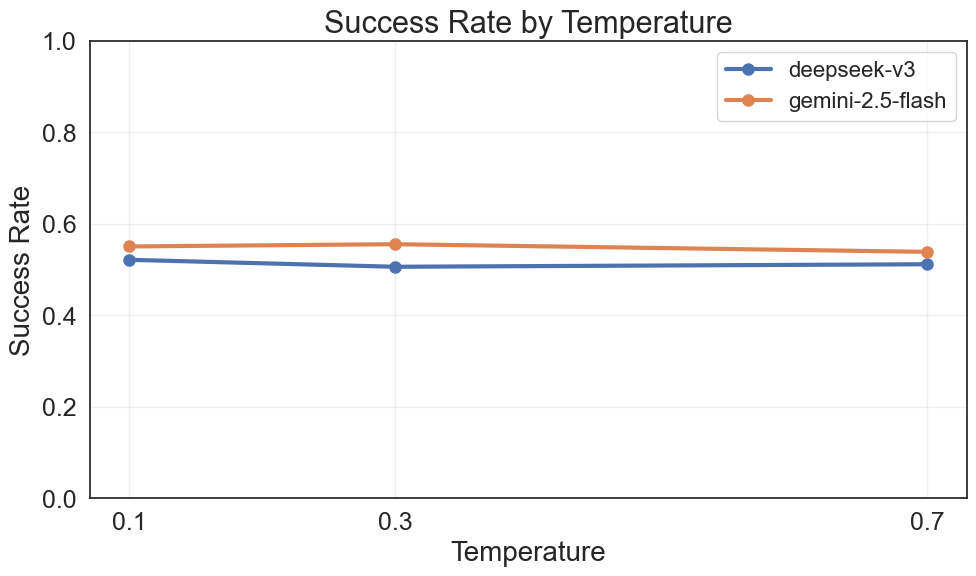


成功率汇总表:
deepseek-v3 (温度=0.1): 750/1440 = 0.5208 (52.08%)
deepseek-v3 (温度=0.3): 728/1440 = 0.5056 (50.56%)
deepseek-v3 (温度=0.7): 736/1440 = 0.5111 (51.11%)
gemini-2.5-flash (温度=0.1): 792/1440 = 0.5500 (55.00%)
gemini-2.5-flash (温度=0.3): 799/1440 = 0.5549 (55.49%)
gemini-2.5-flash (温度=0.7): 775/1440 = 0.5382 (53.82%)
→ 成功率折线图已保存至 figures/ 目录


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pathlib

# ---------- 加载数据 ----------
results_path = "results/quantitative_analysis_20250717_213821/quantitative_analysis_merged_20250717_213821.csv"
df = pd.read_csv(results_path)

# ---------- 数据过滤 ----------
# Filter for specific models
target_models = ['deepseek/deepseek-chat-v3-0324', 'google/gemini-2.5-flash']
df_filtered = df[df['hinter_model'].isin(target_models)].copy()

# Filter for specific temperatures
target_temperatures = [0.1, 0.3, 0.7]
df_filtered = df_filtered[df_filtered['temperature'].isin(target_temperatures)]

# ---------- 模型名称映射 ----------
label_map = {
    "deepseek/deepseek-chat-v3-0324": "deepseek-v3",
    "google/gemini-2.5-flash": "gemini-2.5-flash",
}

# 应用模型名称映射
df_filtered['model_short'] = df_filtered['hinter_model'].map(label_map)

# ---------- 计算成功率 ----------
success_rates = df_filtered.groupby(['model_short', 'temperature']).agg({
    'success': ['count', 'sum']
}).round(4)

# Flatten column names
success_rates.columns = ['total_count', 'success_count']
success_rates['success_rate'] = (success_rates['success_count'] / success_rates['total_count']).round(4)
success_rates = success_rates.reset_index()

print("成功率数据:")
print(success_rates)

# ---------- 设置绘图风格 ----------
sns.set_theme(style="white", font_scale=1.2)
out_dir = pathlib.Path("figures")
out_dir.mkdir(exist_ok=True)

# ---------- 绘制折线图 ----------
plt.figure(figsize=(10, 6))

# 为每个模型绘制折线
for model in success_rates['model_short'].unique():
    model_data = success_rates[success_rates['model_short'] == model]
    plt.plot(model_data['temperature'], model_data['success_rate'], 
             marker='o', linewidth=3, markersize=8, label=model)

plt.ylabel("Success Rate", fontsize=20)
plt.xlabel("Temperature", fontsize=20)
plt.xticks(target_temperatures, fontsize=18)
plt.yticks(fontsize=18)

# 设置y轴范围，让图表更清晰
plt.ylim(0, 1)

# 添加网格
plt.grid(True, alpha=0.3)

# 添加图例
plt.legend(fontsize=16, loc='best')

plt.title("Success Rate by Temperature", fontsize=22)
plt.tight_layout()

# 保存图表
plt.savefig(out_dir / "Success_Rate_by_Temperature.pdf", bbox_inches="tight")
plt.savefig(out_dir / "Success_Rate_by_Temperature.png", dpi=300, bbox_inches="tight")
plt.show()

# ---------- 打印详细统计 ----------
print("\n成功率汇总表:")
for (model, temp), group in df_filtered.groupby(['model_short', 'temperature']):
    total = len(group)
    successes = group['success'].sum()
    rate = successes / total if total > 0 else 0
    print(f"{model} (温度={temp}): {successes}/{total} = {rate:.4f} ({rate*100:.2f}%)")

print("→ 成功率折线图已保存至 figures/ 目录")

原始数据行数: 8640
过滤后数据行数: 8640
过滤后的模型: ['deepseek/deepseek-chat-v3-0324' 'google/gemini-2.5-flash']
过滤后的温度: [np.float64(0.1), np.float64(0.3), np.float64(0.7)]
过滤后的taboo_count: [np.int64(1), np.int64(3), np.int64(5)]
过滤后的hint_word_count: [np.int64(1), np.int64(5), np.int64(10)]

========== Taboo Count = 1 ==========

DeepSeek-V3 成功率矩阵（taboo_count=1）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.487	0.350	0.419	
5				0.606	0.662	0.600	
10				0.688	0.669	0.650	

Gemini-2.5-Flash 成功率矩阵（taboo_count=1）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.394	0.362	0.331	
5				0.569	0.625	0.613	
10				0.750	0.731	0.725	


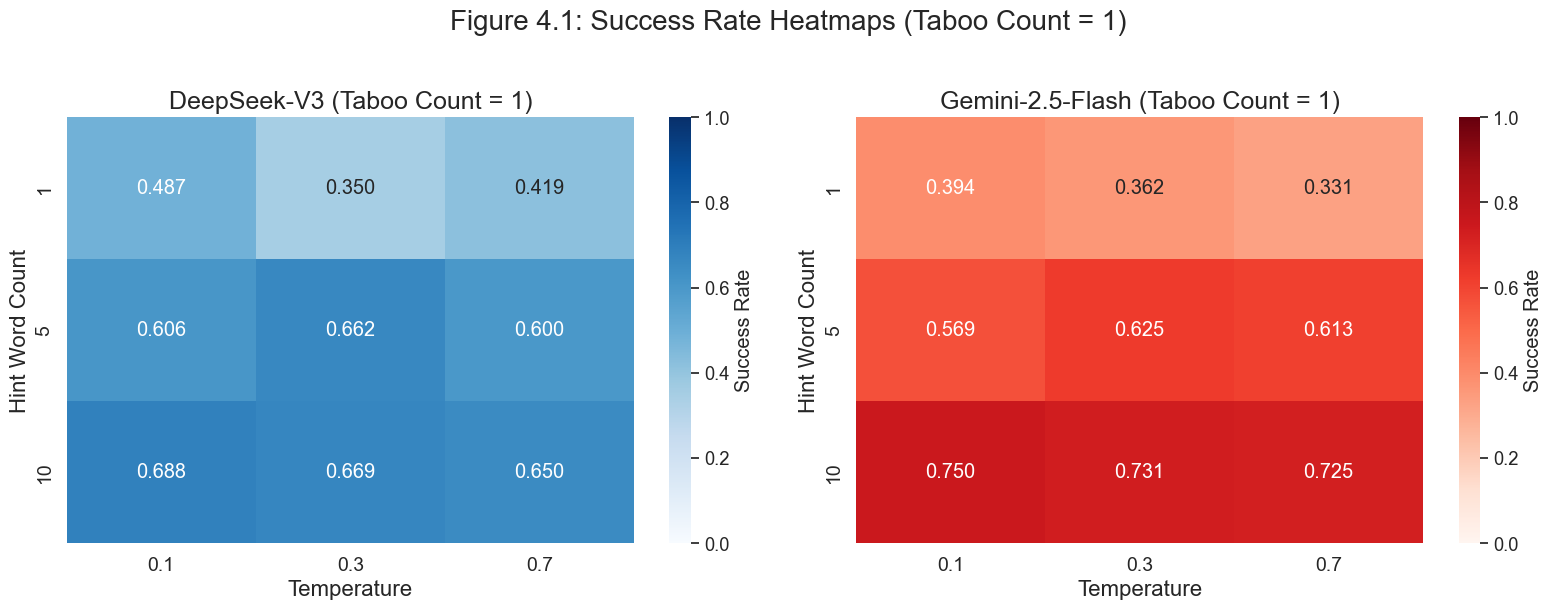


========== Taboo Count = 3 ==========

DeepSeek-V3 成功率矩阵（taboo_count=3）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.412	0.362	0.425	
5				0.519	0.544	0.506	
10				0.569	0.588	0.600	

Gemini-2.5-Flash 成功率矩阵（taboo_count=3）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.356	0.369	0.350	
5				0.619	0.625	0.556	
10				0.719	0.738	0.756	


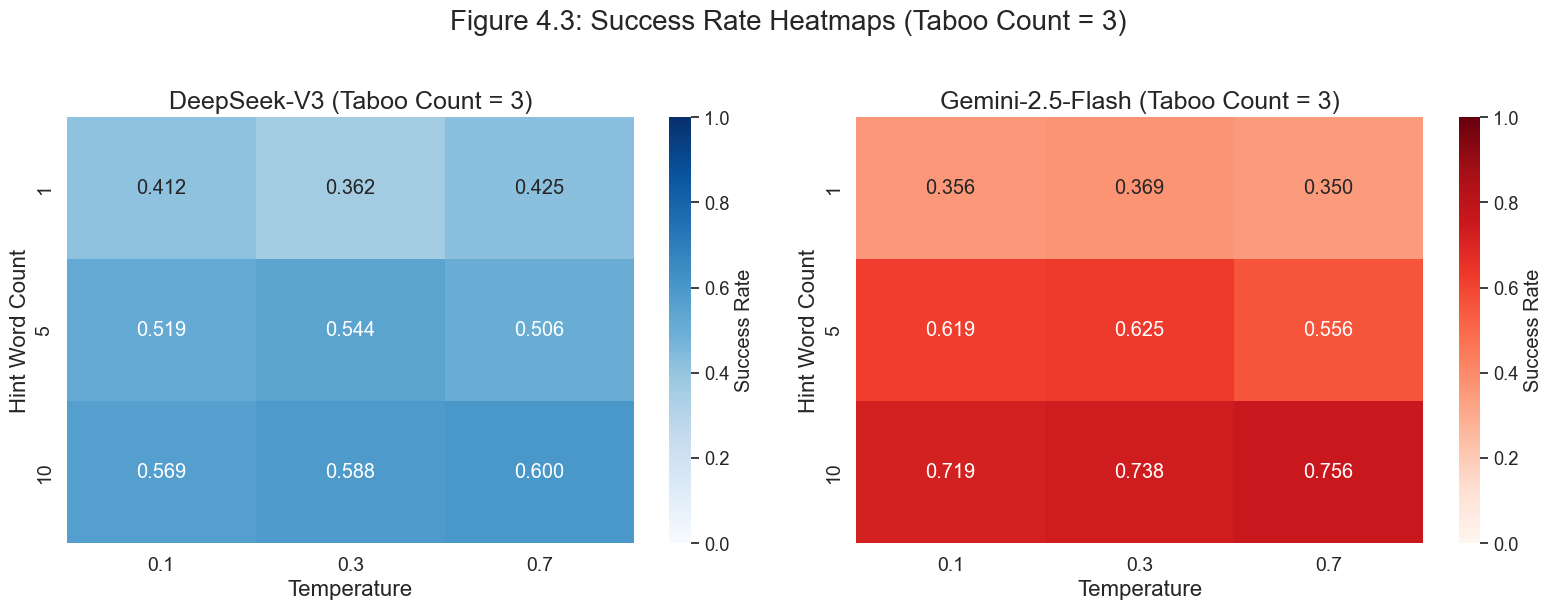


========== Taboo Count = 5 ==========

DeepSeek-V3 成功率矩阵（taboo_count=5）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.425	0.300	0.388	
5				0.469	0.525	0.512	
10				0.512	0.550	0.500	

Gemini-2.5-Flash 成功率矩阵（taboo_count=5）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.325	0.350	0.306	
5				0.550	0.525	0.550	
10				0.669	0.669	0.656	


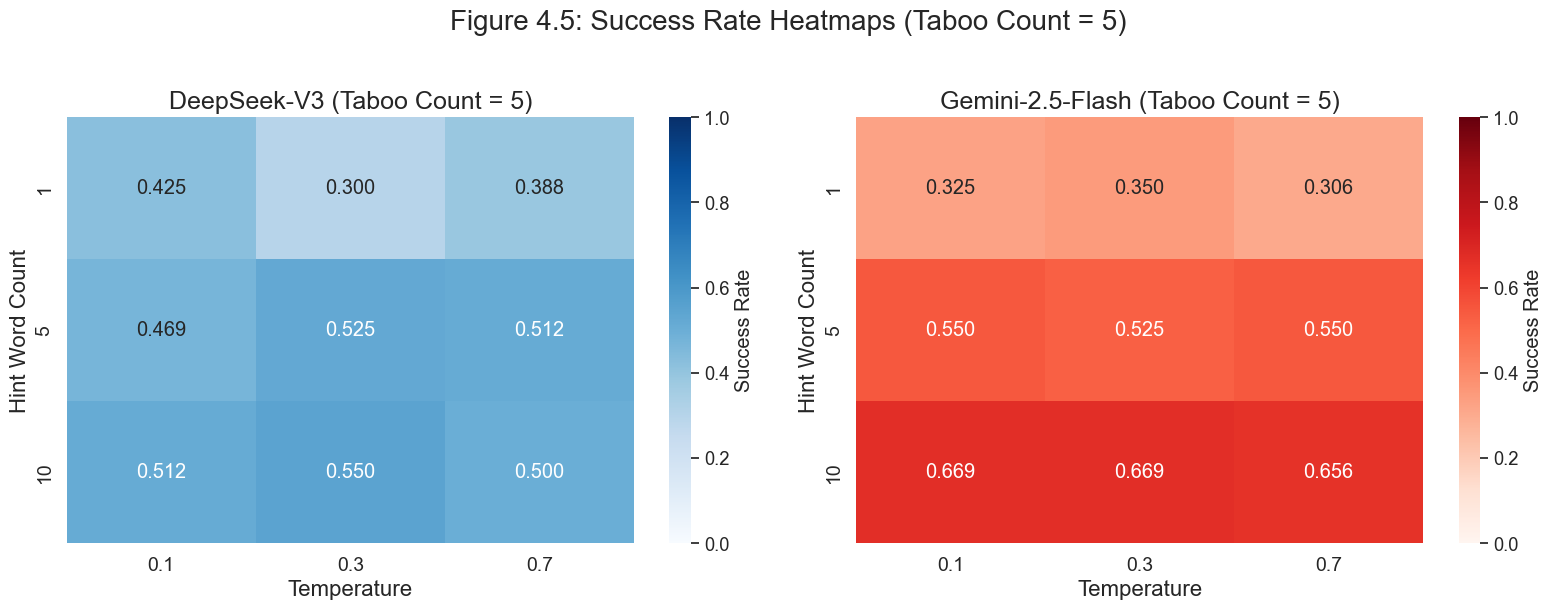


→ 所有热力图已保存至 figures/ 目录

========== 整体统计汇总 ==========
详细统计表:
     model_short  taboo_count  hint_word_count  temperature  total_count  success_count  success_rate
     DeepSeek-V3            1                1          0.1          160             78       0.48750
     DeepSeek-V3            1                1          0.3          160             56       0.35000
     DeepSeek-V3            1                1          0.7          160             67       0.41875
     DeepSeek-V3            1                5          0.1          160             97       0.60625
     DeepSeek-V3            1                5          0.3          160            106       0.66250
     DeepSeek-V3            1                5          0.7          160             96       0.60000
     DeepSeek-V3            1               10          0.1          160            110       0.68750
     DeepSeek-V3            1               10          0.3          160            107       0.66875
     DeepSeek-V3    

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pathlib

# ---------- 加载数据 ----------
results_path = "results/quantitative_analysis_20250717_213821/quantitative_analysis_merged_20250717_213821.csv"
df = pd.read_csv(results_path)

# ---------- 数据过滤 ----------
# Filter for specific models
target_models = ['deepseek/deepseek-chat-v3-0324', 'google/gemini-2.5-flash']
df_filtered = df[df['hinter_model'].isin(target_models)].copy()

# Filter for specific temperatures
target_temperatures = [0.1, 0.3, 0.7]
df_filtered = df_filtered[df_filtered['temperature'].isin(target_temperatures)]

# Filter for specific taboo_counts
target_taboo_counts = [1, 3, 5]
df_filtered = df_filtered[df_filtered['taboo_count'].isin(target_taboo_counts)]

# Filter for specific hint_word_counts (对应hint_length)
target_hint_lengths = [1, 5, 10]
df_filtered = df_filtered[df_filtered['hint_word_count'].isin(target_hint_lengths)]

print(f"原始数据行数: {len(df)}")
print(f"过滤后数据行数: {len(df_filtered)}")
print(f"过滤后的模型: {df_filtered['hinter_model'].unique()}")
print(f"过滤后的温度: {sorted(df_filtered['temperature'].unique())}")
print(f"过滤后的taboo_count: {sorted(df_filtered['taboo_count'].unique())}")
print(f"过滤后的hint_word_count: {sorted(df_filtered['hint_word_count'].unique())}")

# ---------- 模型名称映射 ----------
label_map = {
    "deepseek/deepseek-chat-v3-0324": "DeepSeek-V3",
    "google/gemini-2.5-flash": "Gemini-2.5-Flash",
}

# 应用模型名称映射
df_filtered['model_short'] = df_filtered['hinter_model'].map(label_map)

# ---------- 设置绘图风格 ----------
sns.set_theme(style="white", font_scale=1.2)
out_dir = pathlib.Path("figures")
out_dir.mkdir(exist_ok=True)

# ---------- 数据准备和可视化 ----------
for taboo_count in target_taboo_counts:
    print(f"\n========== Taboo Count = {taboo_count} ==========")
    
    # 过滤当前taboo_count的数据
    taboo_data = df_filtered[df_filtered['taboo_count'] == taboo_count]
    
    if len(taboo_data) == 0:
        print(f"警告: taboo_count={taboo_count} 没有数据")
        continue
    
    # 为每个模型创建成功率矩阵
    model_matrices = {}
    
    for model in ['DeepSeek-V3', 'Gemini-2.5-Flash']:
        model_data = taboo_data[taboo_data['model_short'] == model]
        
        if len(model_data) == 0:
            print(f"警告: 模型 {model} 在 taboo_count={taboo_count} 时没有数据")
            # 创建空的矩阵
            pivot_table = pd.DataFrame(index=target_hint_lengths, columns=target_temperatures)
            pivot_table = pivot_table.fillna(0)  # 用0填充
            model_matrices[model] = pivot_table
            continue
        
        # 计算成功率
        success_rates = model_data.groupby(['hint_word_count', 'temperature']).agg({
            'success': ['count', 'sum']
        })
        success_rates.columns = ['total_count', 'success_count']
        success_rates['success_rate'] = success_rates['success_count'] / success_rates['total_count']
        success_rates = success_rates.reset_index()
        
        # 创建透视表用于热力图
        pivot_table = success_rates.pivot(index='hint_word_count', columns='temperature', values='success_rate')
        
        # 确保所有组合都存在，用NaN填充缺失值
        pivot_table = pivot_table.reindex(index=target_hint_lengths, columns=target_temperatures)
        
        model_matrices[model] = pivot_table
        
        # 打印成功率表
        print(f"\n{model} 成功率矩阵（taboo_count={taboo_count}）:")
        print("hint_word_count ↓ \\ temperature →\t", end="")
        for temp in target_temperatures:
            print(f"{temp}\t", end="")
        print()
        
        for hint_len in target_hint_lengths:
            print(f"{hint_len}\t\t\t\t", end="")
            for temp in target_temperatures:
                if hint_len in pivot_table.index and temp in pivot_table.columns:
                    rate = pivot_table.loc[hint_len, temp]
                    if pd.isna(rate):
                        print("N/A\t", end="")
                    else:
                        print(f"{rate:.3f}\t", end="")
                else:
                    print("N/A\t", end="")
            print()
    
    # ---------- 绘制并排热力图 ----------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # DeepSeek热力图
    sns.heatmap(model_matrices['DeepSeek-V3'], 
                annot=True, fmt='.3f', cmap='Blues', 
                cbar_kws={'label': 'Success Rate'},
                ax=ax1, vmin=0, vmax=1)
    ax1.set_title(f'DeepSeek-V3 (Taboo Count = {taboo_count})', fontsize=18)
    ax1.set_xlabel('Temperature', fontsize=16)
    ax1.set_ylabel('Hint Word Count', fontsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    
    # Gemini热力图
    sns.heatmap(model_matrices['Gemini-2.5-Flash'], 
                annot=True, fmt='.3f', cmap='Reds', 
                cbar_kws={'label': 'Success Rate'},
                ax=ax2, vmin=0, vmax=1)
    ax2.set_title(f'Gemini-2.5-Flash (Taboo Count = {taboo_count})', fontsize=18)
    ax2.set_xlabel('Temperature', fontsize=16)
    ax2.set_ylabel('Hint Word Count', fontsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    
    # 整体标题
    fig.suptitle(f'Figure 4.{taboo_count}: Success Rate Heatmaps (Taboo Count = {taboo_count})', 
                 fontsize=20, y=1.02)
    
    plt.tight_layout()
    
    # 保存图表
    filename_base = f"Success_Rate_Heatmaps_TabooCount_{taboo_count}"
    plt.savefig(out_dir / f"{filename_base}.pdf", bbox_inches="tight")
    plt.savefig(out_dir / f"{filename_base}.png", dpi=300, bbox_inches="tight")
    plt.show()

print("\n→ 所有热力图已保存至 figures/ 目录")

# ---------- 整体统计汇总 ----------
print("\n========== 整体统计汇总 ==========")
overall_stats = df_filtered.groupby(['model_short', 'taboo_count', 'hint_word_count', 'temperature']).agg({
    'success': ['count', 'sum']
})
overall_stats.columns = ['total_count', 'success_count']
overall_stats['success_rate'] = overall_stats['success_count'] / overall_stats['total_count']
overall_stats = overall_stats.reset_index()

print("详细统计表:")
print(overall_stats.to_string(index=False))

开始定量分析成功率热力图生成...
加载定量分析数据...
原始数据行数: 8640
过滤后数据行数: 8640
过滤后的模型: ['deepseek/deepseek-chat-v3-0324' 'google/gemini-2.5-flash']
过滤后的温度: [np.float64(0.1), np.float64(0.3), np.float64(0.7)]
过滤后的taboo_count: [np.int64(1), np.int64(3), np.int64(5)]
过滤后的hint_word_count: [np.int64(1), np.int64(5), np.int64(10)]
生成单独热力图...

处理 Taboo Count = 1

DeepSeek-V3 成功率矩阵（taboo_count=1）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.487	0.350	0.419	
5				0.606	0.662	0.600	
10				0.688	0.669	0.650	
✓ 图4.28已保存


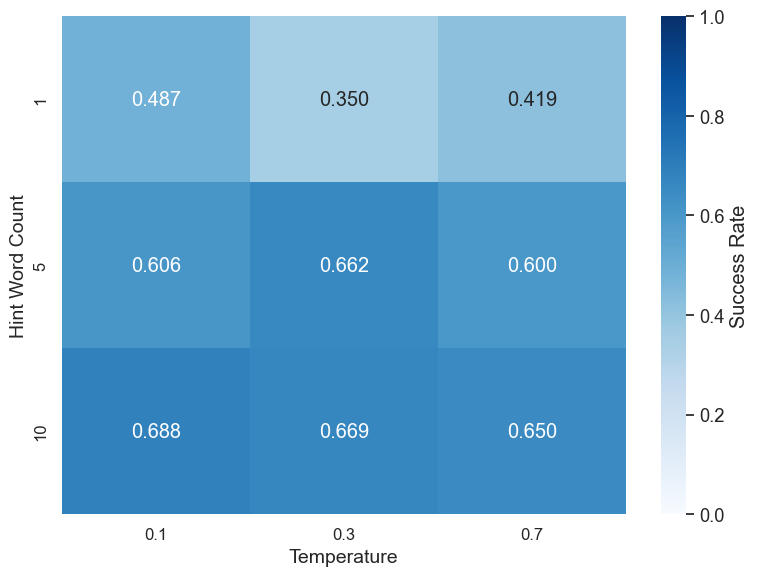


Gemini-2.5-Flash 成功率矩阵（taboo_count=1）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.394	0.362	0.331	
5				0.569	0.625	0.613	
10				0.750	0.731	0.725	
✓ 图4.29已保存


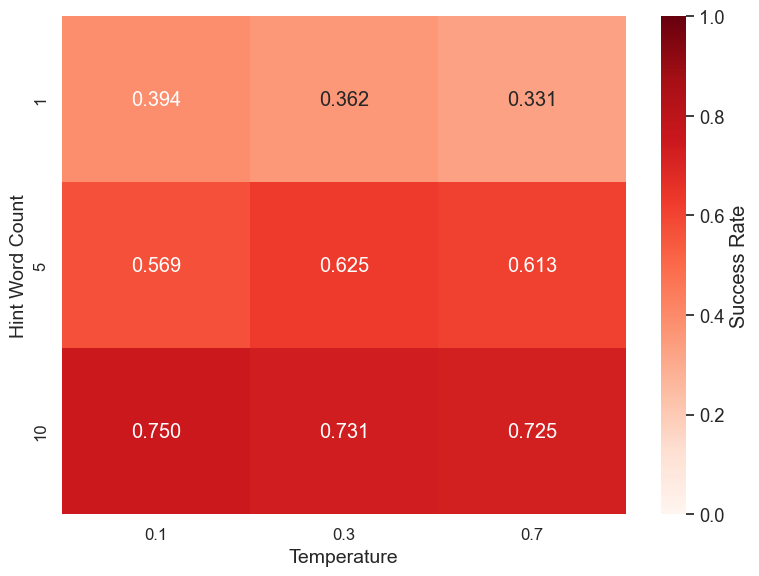


处理 Taboo Count = 3

DeepSeek-V3 成功率矩阵（taboo_count=3）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.412	0.362	0.425	
5				0.519	0.544	0.506	
10				0.569	0.588	0.600	
✓ 图4.30已保存


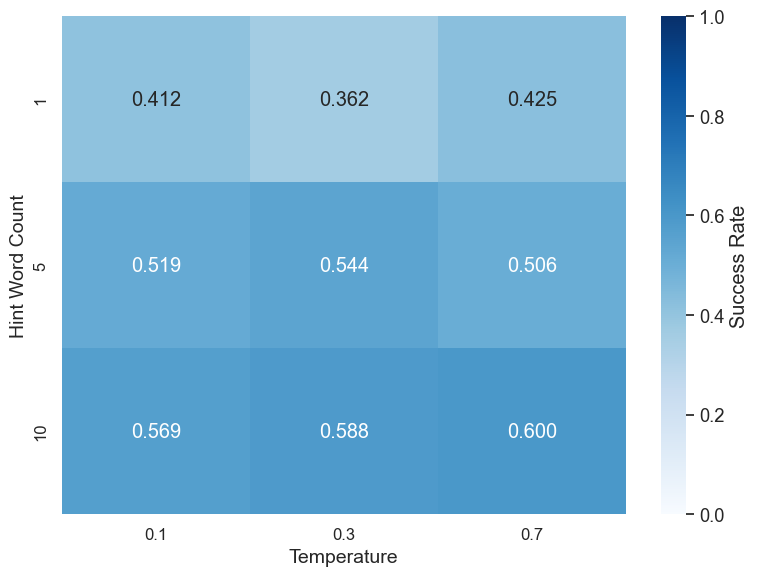


Gemini-2.5-Flash 成功率矩阵（taboo_count=3）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.356	0.369	0.350	
5				0.619	0.625	0.556	
10				0.719	0.738	0.756	
✓ 图4.31已保存


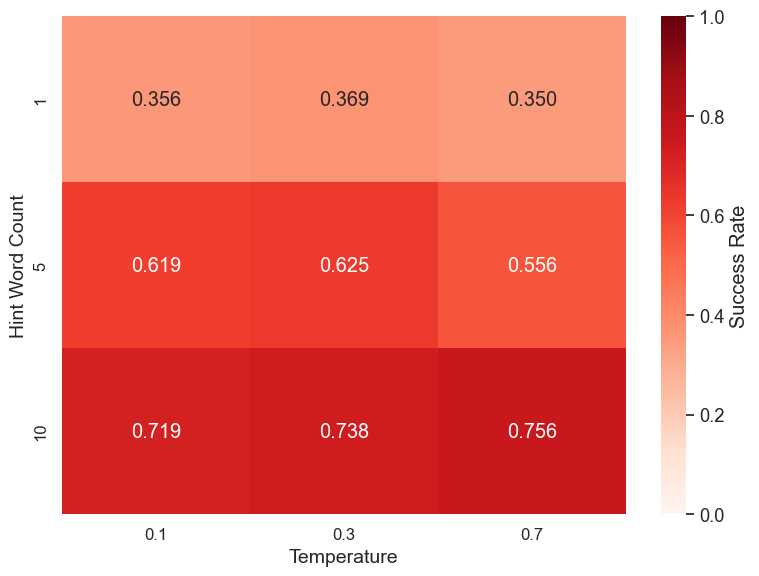


处理 Taboo Count = 5

DeepSeek-V3 成功率矩阵（taboo_count=5）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.425	0.300	0.388	
5				0.469	0.525	0.512	
10				0.512	0.550	0.500	
✓ 图4.32已保存


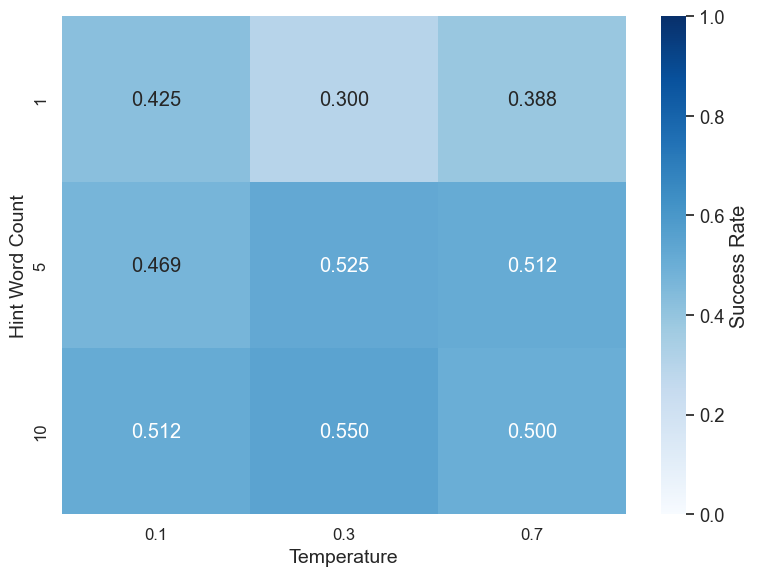


Gemini-2.5-Flash 成功率矩阵（taboo_count=5）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.325	0.350	0.306	
5				0.550	0.525	0.550	
10				0.669	0.669	0.656	
✓ 图4.33已保存


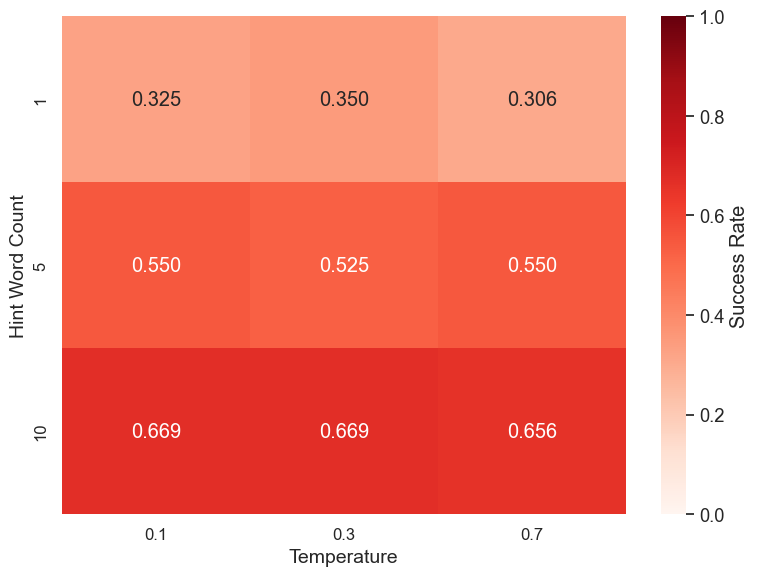

生成并排对比热力图...

处理 Taboo Count = 1 并排图
✓ 并排热力图（taboo_count=1）已保存


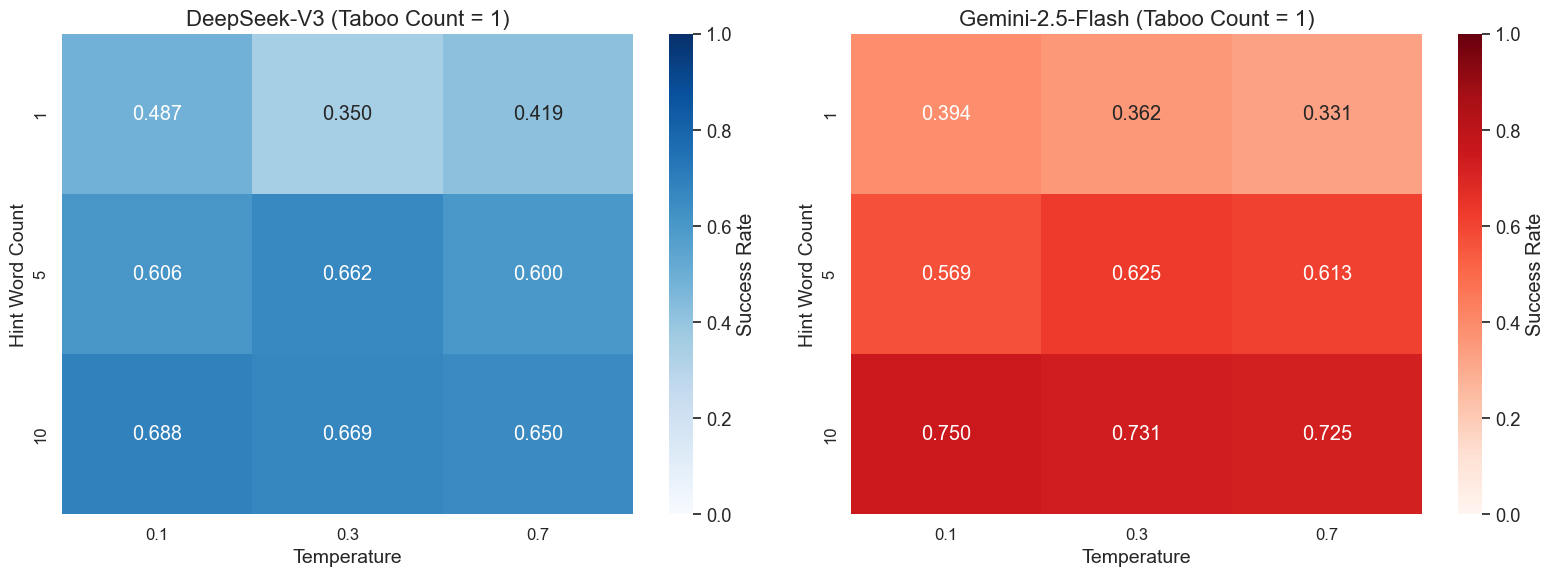


处理 Taboo Count = 3 并排图
✓ 并排热力图（taboo_count=3）已保存


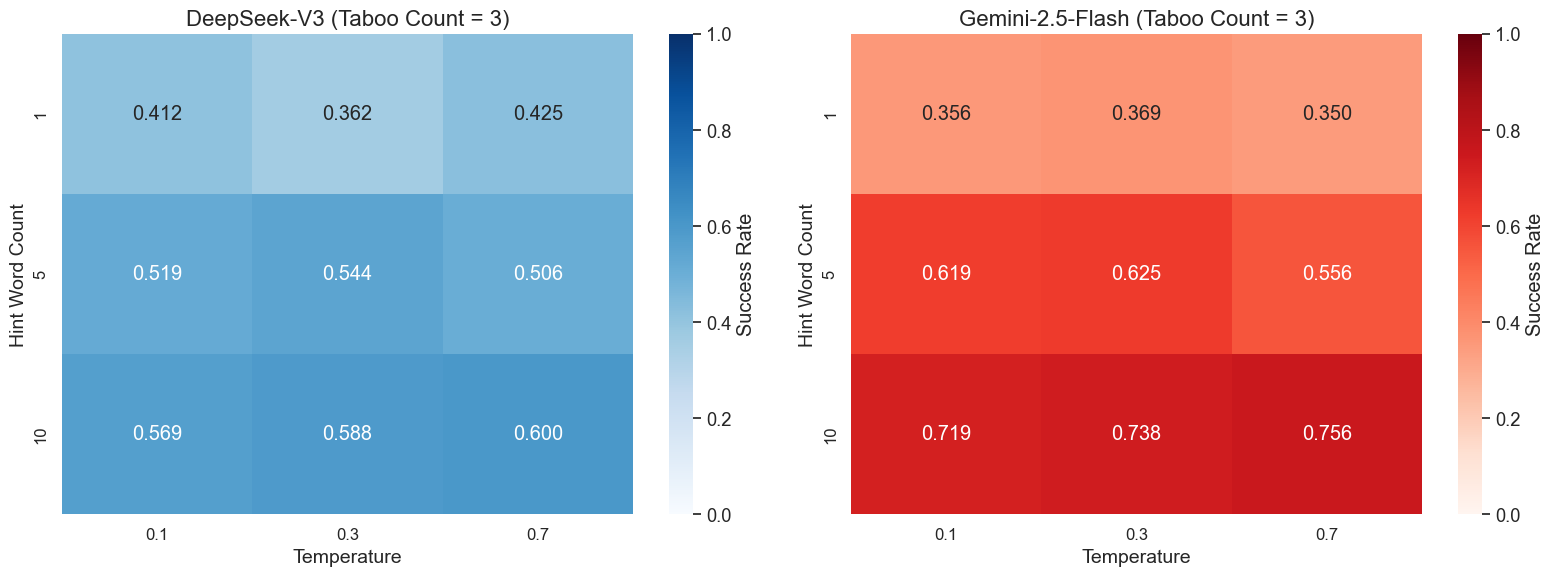


处理 Taboo Count = 5 并排图
✓ 并排热力图（taboo_count=5）已保存


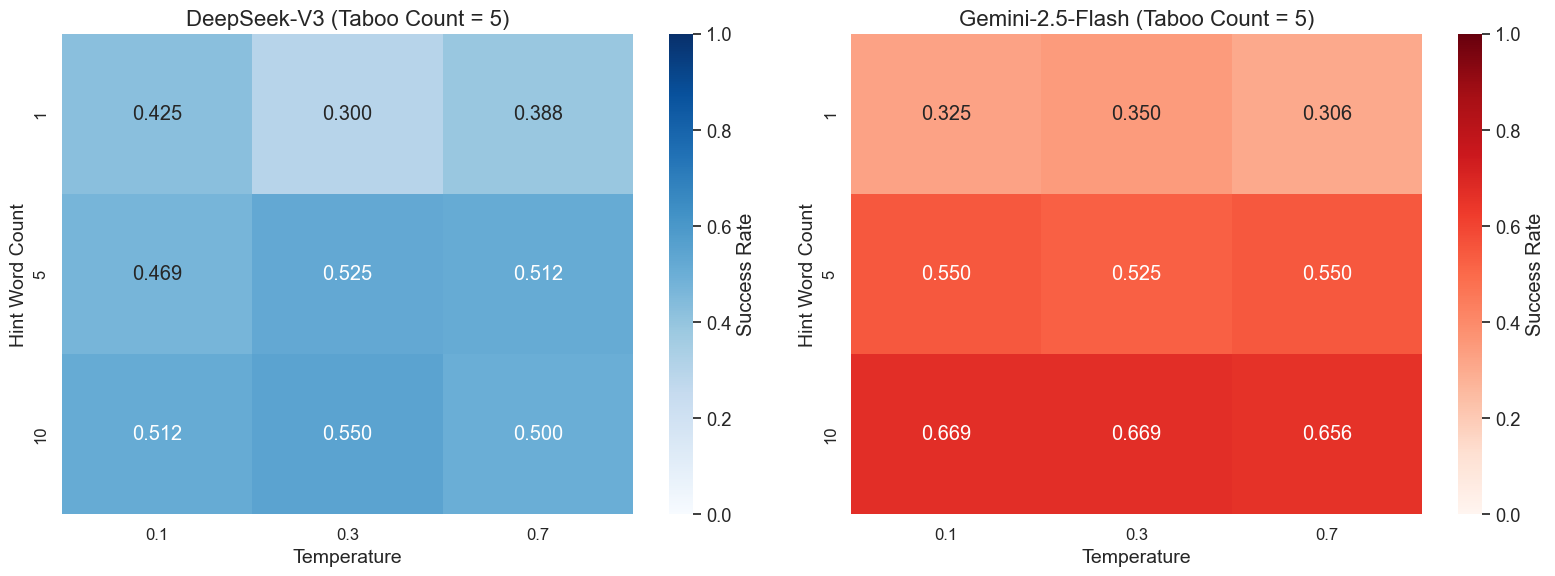


整体统计汇总
详细统计表:
     model_short  taboo_count  hint_word_count  temperature  total_count  success_count  success_rate
     DeepSeek-V3            1                1          0.1          160             78       0.48750
     DeepSeek-V3            1                1          0.3          160             56       0.35000
     DeepSeek-V3            1                1          0.7          160             67       0.41875
     DeepSeek-V3            1                5          0.1          160             97       0.60625
     DeepSeek-V3            1                5          0.3          160            106       0.66250
     DeepSeek-V3            1                5          0.7          160             96       0.60000
     DeepSeek-V3            1               10          0.1          160            110       0.68750
     DeepSeek-V3            1               10          0.3          160            107       0.66875
     DeepSeek-V3            1               10          0.7        

In [1]:
#!/usr/bin/env python3
"""
定量分析成功率热力图 - 生成图4.28-4.33
Quantitative Analysis Success Rate Heatmaps - Figures 4.28-4.33
"""

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# 设置绘图风格
sns.set_theme(style="white", font_scale=1.2)

def load_and_process_data():
    """加载并处理定量分析数据"""
    print("加载定量分析数据...")
    
    results_path = "results/quantitative_analysis_20250717_213821/quantitative_analysis_merged_20250717_213821.csv"
    df = pd.read_csv(results_path)
    
    print(f"原始数据行数: {len(df)}")
    
    # 过滤特定模型
    target_models = ['deepseek/deepseek-chat-v3-0324', 'google/gemini-2.5-flash']
    df_filtered = df[df['hinter_model'].isin(target_models)].copy()
    
    # 过滤特定温度
    target_temperatures = [0.1, 0.3, 0.7]
    df_filtered = df_filtered[df_filtered['temperature'].isin(target_temperatures)]
    
    # 过滤特定禁忌词数量
    target_taboo_counts = [1, 3, 5]
    df_filtered = df_filtered[df_filtered['taboo_count'].isin(target_taboo_counts)]
    
    # 过滤特定提示词长度
    target_hint_lengths = [1, 5, 10]
    df_filtered = df_filtered[df_filtered['hint_word_count'].isin(target_hint_lengths)]
    
    print(f"过滤后数据行数: {len(df_filtered)}")
    print(f"过滤后的模型: {df_filtered['hinter_model'].unique()}")
    print(f"过滤后的温度: {sorted(df_filtered['temperature'].unique())}")
    print(f"过滤后的taboo_count: {sorted(df_filtered['taboo_count'].unique())}")
    print(f"过滤后的hint_word_count: {sorted(df_filtered['hint_word_count'].unique())}")
    
    # 模型名称映射
    label_map = {
        "deepseek/deepseek-chat-v3-0324": "DeepSeek-V3",
        "google/gemini-2.5-flash": "Gemini-2.5-Flash",
    }
    
    df_filtered['model_short'] = df_filtered['hinter_model'].map(label_map)
    
    return df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths

def create_success_rate_matrix(data, model, target_hint_lengths, target_temperatures):
    """为指定模型创建成功率矩阵"""
    model_data = data[data['model_short'] == model]
    
    if len(model_data) == 0:
        # 创建空矩阵
        pivot_table = pd.DataFrame(index=target_hint_lengths, columns=target_temperatures)
        pivot_table = pivot_table.fillna(0)
        return pivot_table
    
    # 计算成功率
    success_rates = model_data.groupby(['hint_word_count', 'temperature']).agg({
        'success': ['count', 'sum']
    })
    success_rates.columns = ['total_count', 'success_count']
    success_rates['success_rate'] = success_rates['success_count'] / success_rates['total_count']
    success_rates = success_rates.reset_index()
    
    # 创建透视表
    pivot_table = success_rates.pivot(index='hint_word_count', columns='temperature', values='success_rate')
    
    # 确保所有组合都存在
    pivot_table = pivot_table.reindex(index=target_hint_lengths, columns=target_temperatures)
    
    return pivot_table

def create_individual_heatmaps(df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths):
    """创建单独的热力图（图4.28-4.33）"""
    print("生成单独热力图...")
    
    # 确保figures目录存在
    os.makedirs('figures', exist_ok=True)
    
    figure_numbers = {
        ('DeepSeek-V3', 1): '4.28',
        ('Gemini-2.5-Flash', 1): '4.29',
        ('DeepSeek-V3', 3): '4.30',
        ('Gemini-2.5-Flash', 3): '4.31',
        ('DeepSeek-V3', 5): '4.32',
        ('Gemini-2.5-Flash', 5): '4.33'
    }
    
    for taboo_count in target_taboo_counts:
        print(f"\n处理 Taboo Count = {taboo_count}")
        
        # 过滤当前taboo_count的数据
        taboo_data = df_filtered[df_filtered['taboo_count'] == taboo_count]
        
        if len(taboo_data) == 0:
            print(f"警告: taboo_count={taboo_count} 没有数据")
            continue
        
        for model in ['DeepSeek-V3', 'Gemini-2.5-Flash']:
            # 创建成功率矩阵
            pivot_table = create_success_rate_matrix(taboo_data, model, target_hint_lengths, target_temperatures)
            
            # 打印成功率表
            print(f"\n{model} 成功率矩阵（taboo_count={taboo_count}）:")
            print("hint_word_count ↓ \\ temperature →\t", end="")
            for temp in target_temperatures:
                print(f"{temp}\t", end="")
            print()
            
            for hint_len in target_hint_lengths:
                print(f"{hint_len}\t\t\t\t", end="")
                for temp in target_temperatures:
                    if hint_len in pivot_table.index and temp in pivot_table.columns:
                        rate = pivot_table.loc[hint_len, temp]
                        if pd.isna(rate):
                            print("N/A\t", end="")
                        else:
                            print(f"{rate:.3f}\t", end="")
                    else:
                        print("N/A\t", end="")
                print()
            
            # 创建单独热力图
            fig, ax = plt.subplots(figsize=(8, 6))
            
            # 选择颜色方案
            cmap = 'Blues' if model == 'DeepSeek-V3' else 'Reds'
            
            # 绘制热力图
            sns.heatmap(pivot_table, 
                       annot=True, fmt='.3f', cmap=cmap,
                       cbar_kws={'label': 'Success Rate'},
                       ax=ax, vmin=0, vmax=1)
            
            # 设置标题和标签
            figure_num = figure_numbers.get((model, taboo_count), 'X.X')
            ax.set_xlabel('Temperature', fontsize=14)
            ax.set_ylabel('Hint Word Count', fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=12)
            
            plt.tight_layout()
            
            # 保存图表
            filename = f"figure_{figure_num.replace('.', '_')}_{model.lower().replace('-', '_')}_taboo_{taboo_count}_heatmap"
            plt.savefig(f'figures/{filename}.pdf', dpi=300, bbox_inches='tight')
            plt.savefig(f'figures/{filename}.png', dpi=300, bbox_inches='tight')
            print(f"✓ 图{figure_num}已保存")
            
            plt.show()

def create_combined_heatmaps(df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths):
    """创建并排热力图（用于对比）"""
    print("生成并排对比热力图...")
    
    for taboo_count in target_taboo_counts:
        print(f"\n处理 Taboo Count = {taboo_count} 并排图")
        
        # 过滤当前taboo_count的数据
        taboo_data = df_filtered[df_filtered['taboo_count'] == taboo_count]
        
        if len(taboo_data) == 0:
            continue
        
        # 为两个模型创建成功率矩阵
        deepseek_matrix = create_success_rate_matrix(taboo_data, 'DeepSeek-V3', target_hint_lengths, target_temperatures)
        gemini_matrix = create_success_rate_matrix(taboo_data, 'Gemini-2.5-Flash', target_hint_lengths, target_temperatures)
        
        # 创建并排热力图
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # DeepSeek热力图
        sns.heatmap(deepseek_matrix, 
                   annot=True, fmt='.3f', cmap='Blues', 
                   cbar_kws={'label': 'Success Rate'},
                   ax=ax1, vmin=0, vmax=1)
        ax1.set_title(f'DeepSeek-V3 (Taboo Count = {taboo_count})', fontsize=16)
        ax1.set_xlabel('Temperature', fontsize=14)
        ax1.set_ylabel('Hint Word Count', fontsize=14)
        ax1.tick_params(axis='both', which='major', labelsize=12)
        
        # Gemini热力图
        sns.heatmap(gemini_matrix, 
                   annot=True, fmt='.3f', cmap='Reds', 
                   cbar_kws={'label': 'Success Rate'},
                   ax=ax2, vmin=0, vmax=1)
        ax2.set_title(f'Gemini-2.5-Flash (Taboo Count = {taboo_count})', fontsize=16)
        ax2.set_xlabel('Temperature', fontsize=14)
        ax2.set_ylabel('Hint Word Count', fontsize=14)
        ax2.tick_params(axis='both', which='major', labelsize=12)
        
        plt.tight_layout()
        
        # 保存并排图
        filename = f"combined_heatmaps_taboo_count_{taboo_count}"
        plt.savefig(f'figures/{filename}.pdf', dpi=300, bbox_inches='tight')
        plt.savefig(f'figures/{filename}.png', dpi=300, bbox_inches='tight')
        print(f"✓ 并排热力图（taboo_count={taboo_count}）已保存")
        
        plt.show()

def generate_statistics_summary(df_filtered):
    """生成统计汇总"""
    print("\n" + "="*60)
    print("整体统计汇总")
    print("="*60)
    
    overall_stats = df_filtered.groupby(['model_short', 'taboo_count', 'hint_word_count', 'temperature']).agg({
        'success': ['count', 'sum']
    })
    overall_stats.columns = ['total_count', 'success_count']
    overall_stats['success_rate'] = overall_stats['success_count'] / overall_stats['total_count']
    overall_stats = overall_stats.reset_index()
    
    print("详细统计表:")
    print(overall_stats.to_string(index=False))
    
    # 按模型和禁忌词数量汇总
    print(f"\n按模型和禁忌词数量的平均成功率:")
    model_taboo_summary = overall_stats.groupby(['model_short', 'taboo_count'])['success_rate'].mean().reset_index()
    for _, row in model_taboo_summary.iterrows():
        print(f"  {row['model_short']} (taboo_count={row['taboo_count']}): {row['success_rate']:.3f}")

def main():
    print("开始定量分析成功率热力图生成...")
    
    try:
        # 1. 加载和处理数据
        df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths = load_and_process_data()
        
        # 2. 创建单独热力图（图4.28-4.33）
        create_individual_heatmaps(df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths)
        
        # 3. 创建并排对比热力图
        create_combined_heatmaps(df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths)
        
        # 4. 生成统计汇总
        generate_statistics_summary(df_filtered)
        
        print(f"\n✅ 所有热力图已保存到 figures/ 目录")
        print("生成的图表:")
        print("  • 图4.28: DeepSeek-V3在1个禁忌词下的成功率热力图")
        print("  • 图4.29: Gemini-2.5-Flash在1个禁忌词下的成功率热力图")
        print("  • 图4.30: DeepSeek-V3在3个禁忌词下的成功率热力图")
        print("  • 图4.31: Gemini-2.5-Flash在3个禁忌词下的成功率热力图")
        print("  • 图4.32: DeepSeek-V3在5个禁忌词下的成功率热力图")
        print("  • 图4.33: Gemini-2.5-Flash在5个禁忌词下的成功率热力图")
        
    except Exception as e:
        print(f"❌ 分析过程中出现错误: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()


开始定量分析成功率热力图生成...
加载定量分析数据...
原始数据行数: 8640
过滤后数据行数: 8640
过滤后的模型: ['deepseek/deepseek-chat-v3-0324' 'google/gemini-2.5-flash']
过滤后的温度: [np.float64(0.1), np.float64(0.3), np.float64(0.7)]
过滤后的taboo_count: [np.int64(1), np.int64(3), np.int64(5)]
过滤后的hint_word_count: [np.int64(1), np.int64(5), np.int64(10)]
生成单独热力图...

处理 Taboo Count = 1

DeepSeek-V3 成功率矩阵（taboo_count=1）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.487	0.350	0.419	
5				0.606	0.662	0.600	
10				0.688	0.669	0.650	
✓ 图4.28已保存


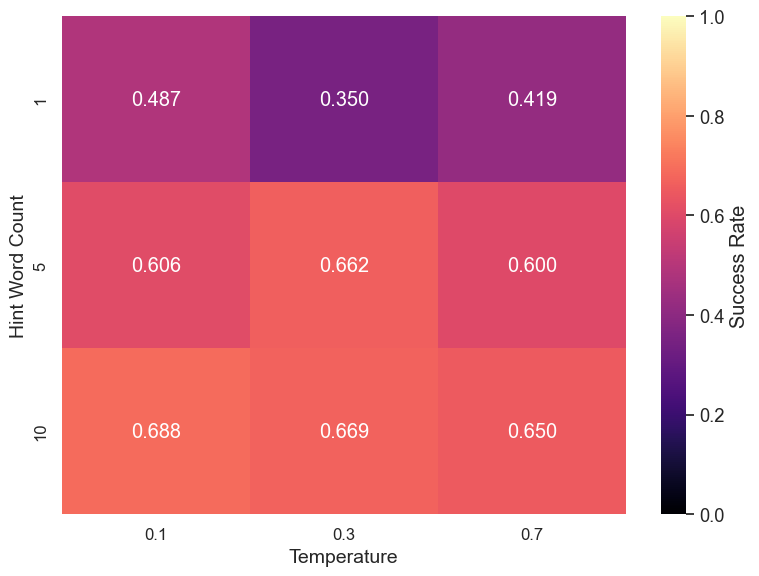


Gemini-2.5-Flash 成功率矩阵（taboo_count=1）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.394	0.362	0.331	
5				0.569	0.625	0.613	
10				0.750	0.731	0.725	
✓ 图4.29已保存


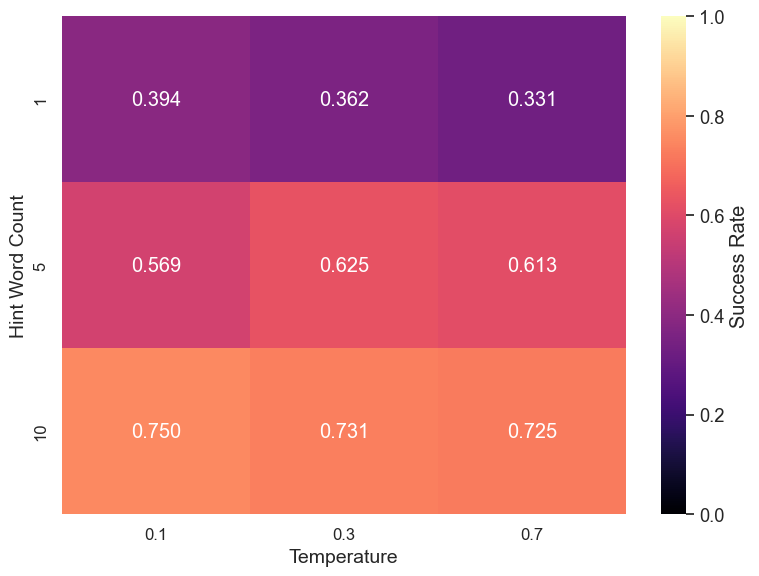


处理 Taboo Count = 3

DeepSeek-V3 成功率矩阵（taboo_count=3）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.412	0.362	0.425	
5				0.519	0.544	0.506	
10				0.569	0.588	0.600	
✓ 图4.30已保存


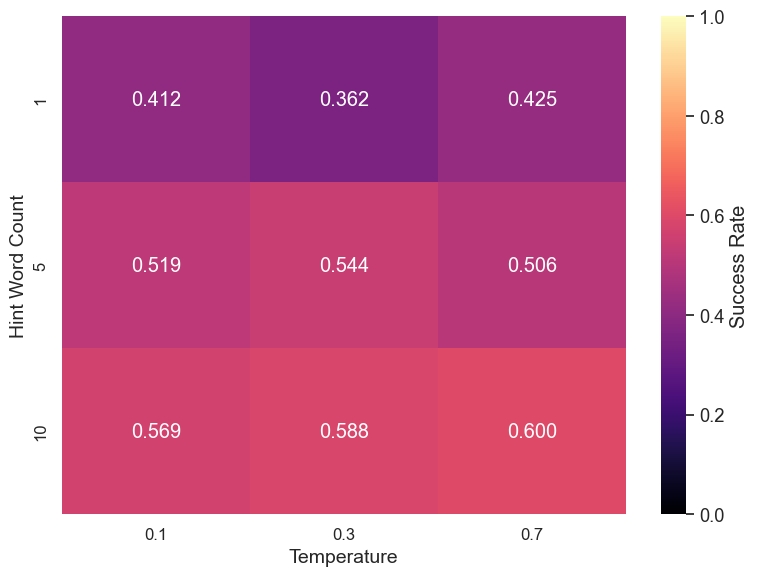


Gemini-2.5-Flash 成功率矩阵（taboo_count=3）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.356	0.369	0.350	
5				0.619	0.625	0.556	
10				0.719	0.738	0.756	
✓ 图4.31已保存


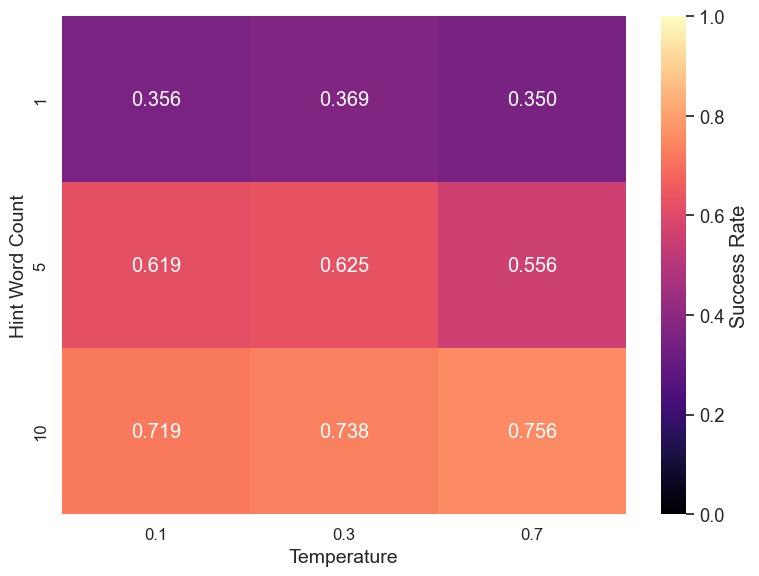


处理 Taboo Count = 5

DeepSeek-V3 成功率矩阵（taboo_count=5）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.425	0.300	0.388	
5				0.469	0.525	0.512	
10				0.512	0.550	0.500	
✓ 图4.32已保存


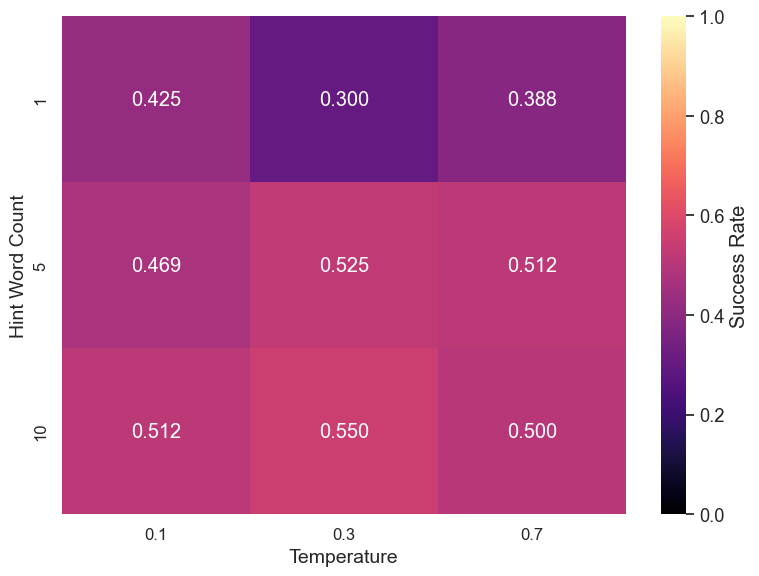


Gemini-2.5-Flash 成功率矩阵（taboo_count=5）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.325	0.350	0.306	
5				0.550	0.525	0.550	
10				0.669	0.669	0.656	
✓ 图4.33已保存


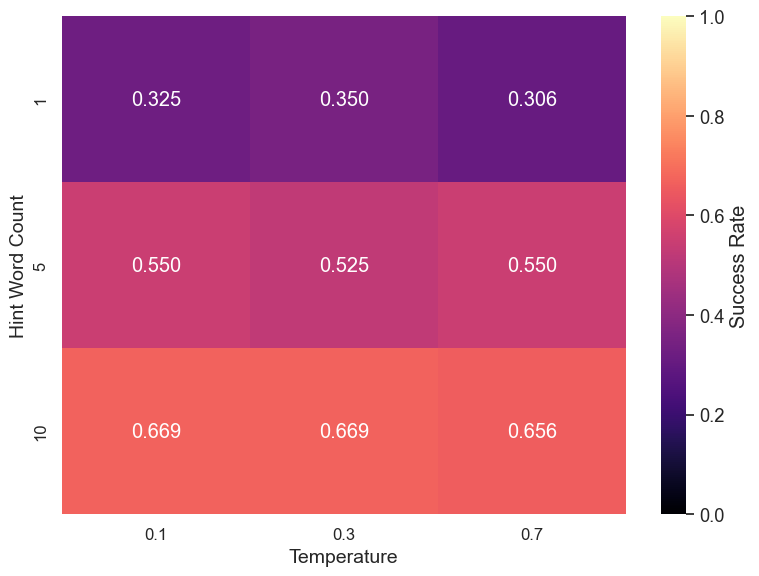

生成并排对比热力图...

处理 Taboo Count = 1 并排图
✓ 并排热力图（taboo_count=1）已保存


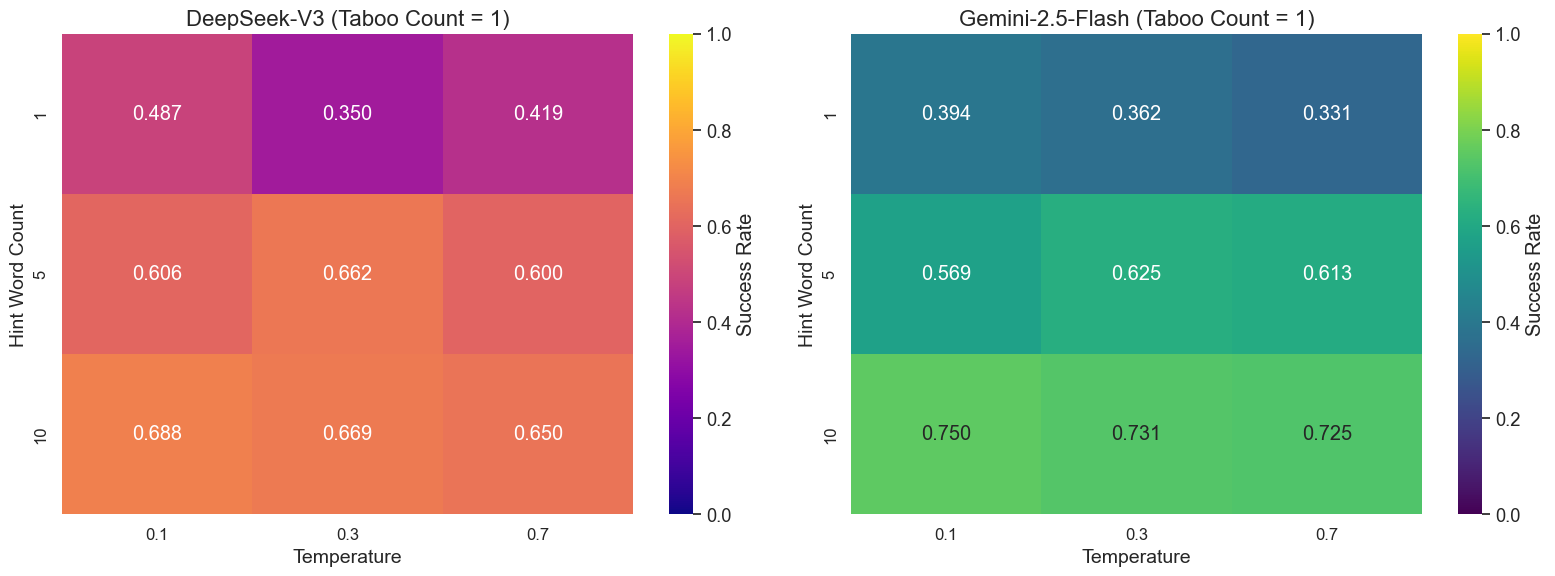


处理 Taboo Count = 3 并排图
✓ 并排热力图（taboo_count=3）已保存


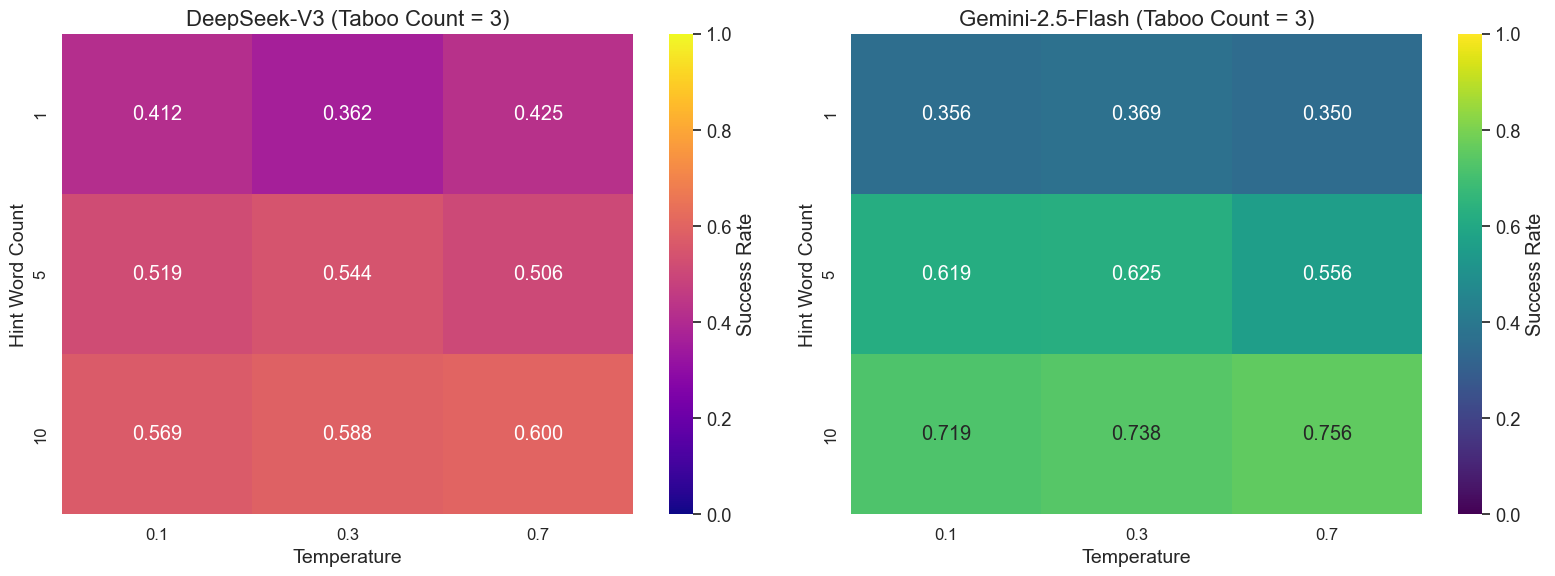


处理 Taboo Count = 5 并排图
✓ 并排热力图（taboo_count=5）已保存


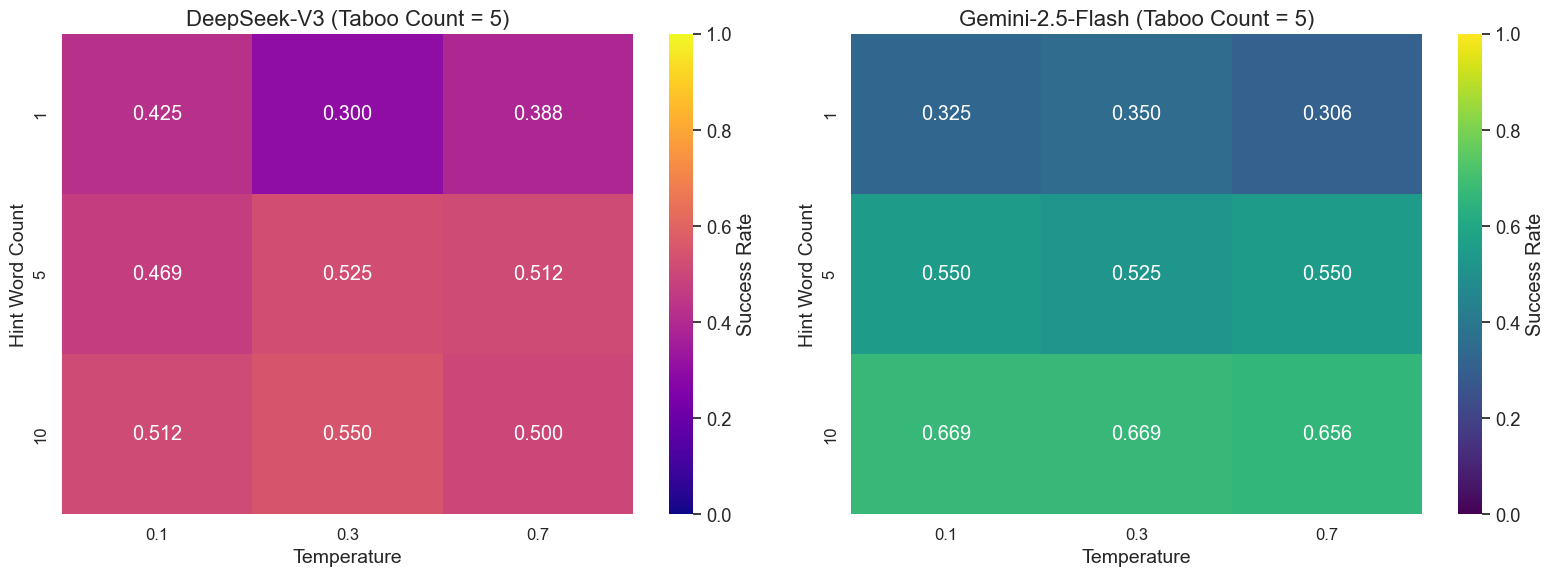


整体统计汇总
详细统计表:
     model_short  taboo_count  hint_word_count  temperature  total_count  success_count  success_rate
     DeepSeek-V3            1                1          0.1          160             78       0.48750
     DeepSeek-V3            1                1          0.3          160             56       0.35000
     DeepSeek-V3            1                1          0.7          160             67       0.41875
     DeepSeek-V3            1                5          0.1          160             97       0.60625
     DeepSeek-V3            1                5          0.3          160            106       0.66250
     DeepSeek-V3            1                5          0.7          160             96       0.60000
     DeepSeek-V3            1               10          0.1          160            110       0.68750
     DeepSeek-V3            1               10          0.3          160            107       0.66875
     DeepSeek-V3            1               10          0.7        

In [3]:
#!/usr/bin/env python3
"""
定量分析成功率热力图 - 生成图4.28-4.33
Quantitative Analysis Success Rate Heatmaps - Figures 4.28-4.33
"""

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# 设置绘图风格
sns.set_theme(style="white", font_scale=1.2)

def load_and_process_data():
    """加载并处理定量分析数据"""
    print("加载定量分析数据...")
    
    results_path = "results/quantitative_analysis_20250717_213821/quantitative_analysis_merged_20250717_213821.csv"
    df = pd.read_csv(results_path)
    
    print(f"原始数据行数: {len(df)}")
    
    # 过滤特定模型
    target_models = ['deepseek/deepseek-chat-v3-0324', 'google/gemini-2.5-flash']
    df_filtered = df[df['hinter_model'].isin(target_models)].copy()
    
    # 过滤特定温度
    target_temperatures = [0.1, 0.3, 0.7]
    df_filtered = df_filtered[df_filtered['temperature'].isin(target_temperatures)]
    
    # 过滤特定禁忌词数量
    target_taboo_counts = [1, 3, 5]
    df_filtered = df_filtered[df_filtered['taboo_count'].isin(target_taboo_counts)]
    
    # 过滤特定提示词长度
    target_hint_lengths = [1, 5, 10]
    df_filtered = df_filtered[df_filtered['hint_word_count'].isin(target_hint_lengths)]
    
    print(f"过滤后数据行数: {len(df_filtered)}")
    print(f"过滤后的模型: {df_filtered['hinter_model'].unique()}")
    print(f"过滤后的温度: {sorted(df_filtered['temperature'].unique())}")
    print(f"过滤后的taboo_count: {sorted(df_filtered['taboo_count'].unique())}")
    print(f"过滤后的hint_word_count: {sorted(df_filtered['hint_word_count'].unique())}")
    
    # 模型名称映射
    label_map = {
        "deepseek/deepseek-chat-v3-0324": "DeepSeek-V3",
        "google/gemini-2.5-flash": "Gemini-2.5-Flash",
    }
    
    df_filtered['model_short'] = df_filtered['hinter_model'].map(label_map)
    
    return df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths

def create_success_rate_matrix(data, model, target_hint_lengths, target_temperatures):
    """为指定模型创建成功率矩阵"""
    model_data = data[data['model_short'] == model]
    
    if len(model_data) == 0:
        # 创建空矩阵
        pivot_table = pd.DataFrame(index=target_hint_lengths, columns=target_temperatures)
        pivot_table = pivot_table.fillna(0)
        return pivot_table
    
    # 计算成功率
    success_rates = model_data.groupby(['hint_word_count', 'temperature']).agg({
        'success': ['count', 'sum']
    })
    success_rates.columns = ['total_count', 'success_count']
    success_rates['success_rate'] = success_rates['success_count'] / success_rates['total_count']
    success_rates = success_rates.reset_index()
    
    # 创建透视表
    pivot_table = success_rates.pivot(index='hint_word_count', columns='temperature', values='success_rate')
    
    # 确保所有组合都存在
    pivot_table = pivot_table.reindex(index=target_hint_lengths, columns=target_temperatures)
    
    return pivot_table

def create_individual_heatmaps(df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths):
    """创建单独的热力图（图4.28-4.33）"""
    print("生成单独热力图...")
    
    # 确保figures目录存在
    os.makedirs('figures', exist_ok=True)
    
    figure_numbers = {
        ('DeepSeek-V3', 1): '4.28',
        ('Gemini-2.5-Flash', 1): '4.29',
        ('DeepSeek-V3', 3): '4.30',
        ('Gemini-2.5-Flash', 3): '4.31',
        ('DeepSeek-V3', 5): '4.32',
        ('Gemini-2.5-Flash', 5): '4.33'
    }
    
    for taboo_count in target_taboo_counts:
        print(f"\n处理 Taboo Count = {taboo_count}")
        
        # 过滤当前taboo_count的数据
        taboo_data = df_filtered[df_filtered['taboo_count'] == taboo_count]
        
        if len(taboo_data) == 0:
            print(f"警告: taboo_count={taboo_count} 没有数据")
            continue
        
        for model in ['DeepSeek-V3', 'Gemini-2.5-Flash']:
            # 创建成功率矩阵
            pivot_table = create_success_rate_matrix(taboo_data, model, target_hint_lengths, target_temperatures)
            
            # 打印成功率表
            print(f"\n{model} 成功率矩阵（taboo_count={taboo_count}）:")
            print("hint_word_count ↓ \\ temperature →\t", end="")
            for temp in target_temperatures:
                print(f"{temp}\t", end="")
            print()
            
            for hint_len in target_hint_lengths:
                print(f"{hint_len}\t\t\t\t", end="")
                for temp in target_temperatures:
                    if hint_len in pivot_table.index and temp in pivot_table.columns:
                        rate = pivot_table.loc[hint_len, temp]
                        if pd.isna(rate):
                            print("N/A\t", end="")
                        else:
                            print(f"{rate:.3f}\t", end="")
                    else:
                        print("N/A\t", end="")
                print()
            
            # 创建单独热力图
            fig, ax = plt.subplots(figsize=(8, 6))
            
            # 使用magma色板保持一致性
            cmap = 'magma'
            
            # 绘制热力图
            sns.heatmap(pivot_table, 
                       annot=True, fmt='.3f', cmap=cmap,
                       cbar_kws={'label': 'Success Rate'},
                       ax=ax, vmin=0, vmax=1)
            
            # 设置标题和标签
            figure_num = figure_numbers.get((model, taboo_count), 'X.X')
            ax.set_xlabel('Temperature', fontsize=14)
            ax.set_ylabel('Hint Word Count', fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=12)
            
            plt.tight_layout()
            
            # 保存图表
            filename = f"figure_{figure_num.replace('.', '_')}_{model.lower().replace('-', '_')}_taboo_{taboo_count}_heatmap"
            plt.savefig(f'figures/{filename}.pdf', dpi=300, bbox_inches='tight')
            plt.savefig(f'figures/{filename}.png', dpi=300, bbox_inches='tight')
            print(f"✓ 图{figure_num}已保存")
            
            plt.show()

def create_combined_heatmaps(df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths):
    """创建并排热力图（用于对比）"""
    print("生成并排对比热力图...")
    
    for taboo_count in target_taboo_counts:
        print(f"\n处理 Taboo Count = {taboo_count} 并排图")
        
        # 过滤当前taboo_count的数据
        taboo_data = df_filtered[df_filtered['taboo_count'] == taboo_count]
        
        if len(taboo_data) == 0:
            continue
        
        # 为两个模型创建成功率矩阵
        deepseek_matrix = create_success_rate_matrix(taboo_data, 'DeepSeek-V3', target_hint_lengths, target_temperatures)
        gemini_matrix = create_success_rate_matrix(taboo_data, 'Gemini-2.5-Flash', target_hint_lengths, target_temperatures)
        
        # 创建并排热力图
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # DeepSeek热力图
        sns.heatmap(deepseek_matrix, 
                   annot=True, fmt='.3f', cmap='plasma', 
                   cbar_kws={'label': 'Success Rate'},
                   ax=ax1, vmin=0, vmax=1)
        ax1.set_title(f'DeepSeek-V3 (Taboo Count = {taboo_count})', fontsize=16)
        ax1.set_xlabel('Temperature', fontsize=14)
        ax1.set_ylabel('Hint Word Count', fontsize=14)
        ax1.tick_params(axis='both', which='major', labelsize=12)
        
        # Gemini热力图
        sns.heatmap(gemini_matrix, 
                   annot=True, fmt='.3f', cmap='viridis', 
                   cbar_kws={'label': 'Success Rate'},
                   ax=ax2, vmin=0, vmax=1)
        ax2.set_title(f'Gemini-2.5-Flash (Taboo Count = {taboo_count})', fontsize=16)
        ax2.set_xlabel('Temperature', fontsize=14)
        ax2.set_ylabel('Hint Word Count', fontsize=14)
        ax2.tick_params(axis='both', which='major', labelsize=12)
        
        plt.tight_layout()
        
        # 保存并排图
        filename = f"combined_heatmaps_taboo_count_{taboo_count}"
        plt.savefig(f'figures/{filename}.pdf', dpi=300, bbox_inches='tight')
        plt.savefig(f'figures/{filename}.png', dpi=300, bbox_inches='tight')
        print(f"✓ 并排热力图（taboo_count={taboo_count}）已保存")
        
        plt.show()

def generate_statistics_summary(df_filtered):
    """生成统计汇总"""
    print("\n" + "="*60)
    print("整体统计汇总")
    print("="*60)
    
    overall_stats = df_filtered.groupby(['model_short', 'taboo_count', 'hint_word_count', 'temperature']).agg({
        'success': ['count', 'sum']
    })
    overall_stats.columns = ['total_count', 'success_count']
    overall_stats['success_rate'] = overall_stats['success_count'] / overall_stats['total_count']
    overall_stats = overall_stats.reset_index()
    
    print("详细统计表:")
    print(overall_stats.to_string(index=False))
    
    # 按模型和禁忌词数量汇总
    print(f"\n按模型和禁忌词数量的平均成功率:")
    model_taboo_summary = overall_stats.groupby(['model_short', 'taboo_count'])['success_rate'].mean().reset_index()
    for _, row in model_taboo_summary.iterrows():
        print(f"  {row['model_short']} (taboo_count={row['taboo_count']}): {row['success_rate']:.3f}")

def main():
    print("开始定量分析成功率热力图生成...")
    
    try:
        # 1. 加载和处理数据
        df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths = load_and_process_data()
        
        # 2. 创建单独热力图（图4.28-4.33）
        create_individual_heatmaps(df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths)
        
        # 3. 创建并排对比热力图
        create_combined_heatmaps(df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths)
        
        # 4. 生成统计汇总
        generate_statistics_summary(df_filtered)
        
        print(f"\n✅ 所有热力图已保存到 figures/ 目录")
        print("生成的图表:")
        print("  • 图4.28: DeepSeek-V3在1个禁忌词下的成功率热力图")
        print("  • 图4.29: Gemini-2.5-Flash在1个禁忌词下的成功率热力图")
        print("  • 图4.30: DeepSeek-V3在3个禁忌词下的成功率热力图")
        print("  • 图4.31: Gemini-2.5-Flash在3个禁忌词下的成功率热力图")
        print("  • 图4.32: DeepSeek-V3在5个禁忌词下的成功率热力图")
        print("  • 图4.33: Gemini-2.5-Flash在5个禁忌词下的成功率热力图")
        
    except Exception as e:
        print(f"❌ 分析过程中出现错误: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()


开始定量分析成功率热力图生成...
加载定量分析数据...
原始数据行数: 8640
过滤后数据行数: 8640
过滤后的模型: ['deepseek/deepseek-chat-v3-0324' 'google/gemini-2.5-flash']
过滤后的温度: [np.float64(0.1), np.float64(0.3), np.float64(0.7)]
过滤后的taboo_count: [np.int64(1), np.int64(3), np.int64(5)]
过滤后的hint_word_count: [np.int64(1), np.int64(5), np.int64(10)]
生成单独热力图...

处理 Taboo Count = 1

DeepSeek-V3 成功率矩阵（taboo_count=1）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.487	0.350	0.419	
5				0.606	0.662	0.600	
10				0.688	0.669	0.650	
✓ 图4.28已保存


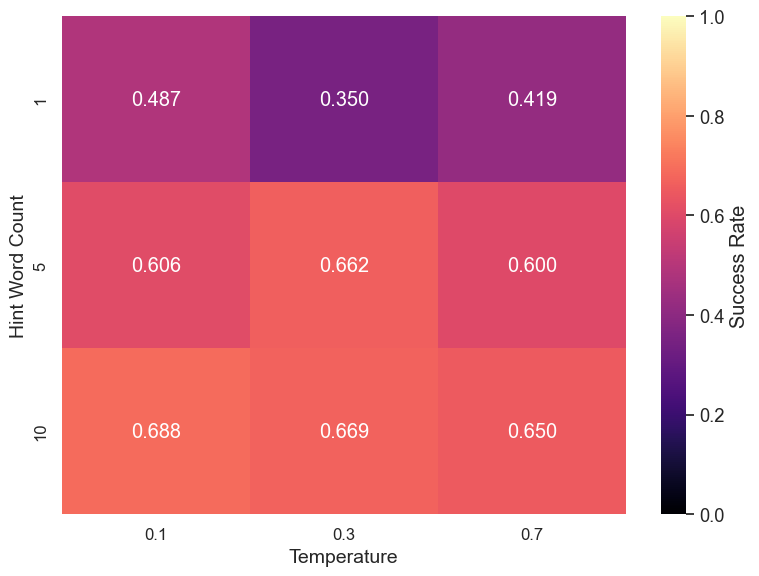


Gemini-2.5-Flash 成功率矩阵（taboo_count=1）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.394	0.362	0.331	
5				0.569	0.625	0.613	
10				0.750	0.731	0.725	
✓ 图4.29已保存


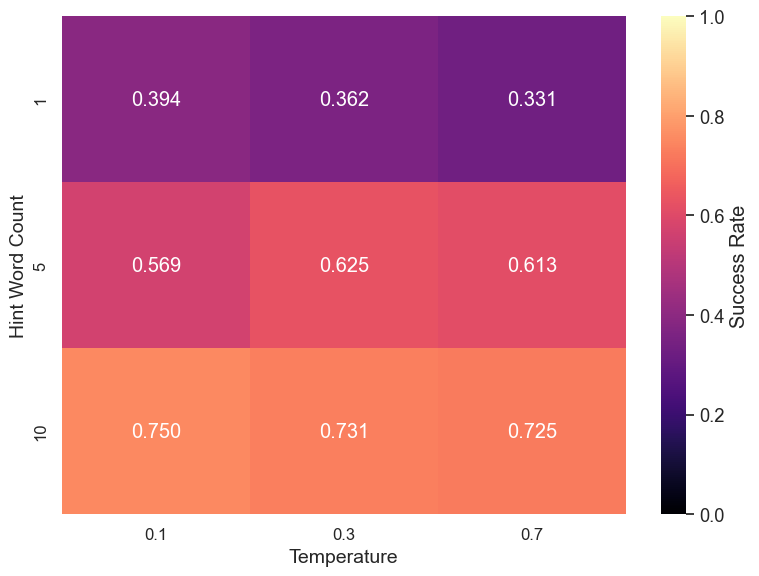


处理 Taboo Count = 3

DeepSeek-V3 成功率矩阵（taboo_count=3）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.412	0.362	0.425	
5				0.519	0.544	0.506	
10				0.569	0.588	0.600	
✓ 图4.30已保存


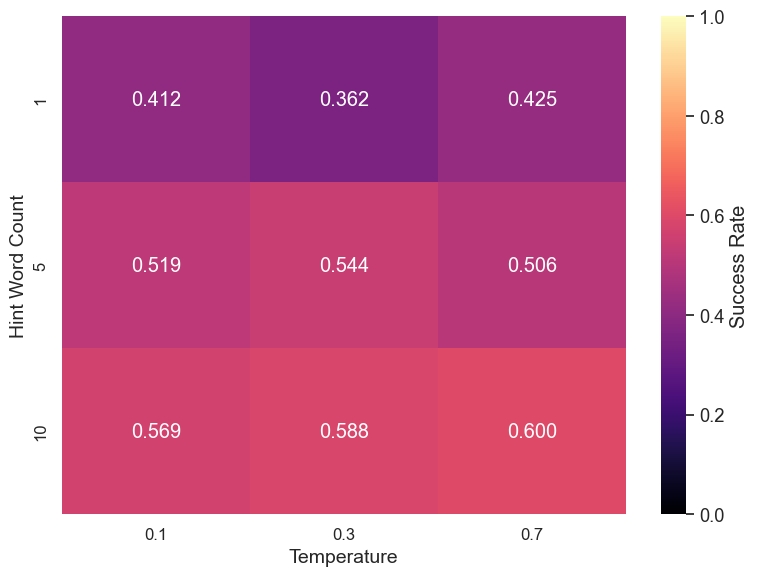


Gemini-2.5-Flash 成功率矩阵（taboo_count=3）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.356	0.369	0.350	
5				0.619	0.625	0.556	
10				0.719	0.738	0.756	
✓ 图4.31已保存


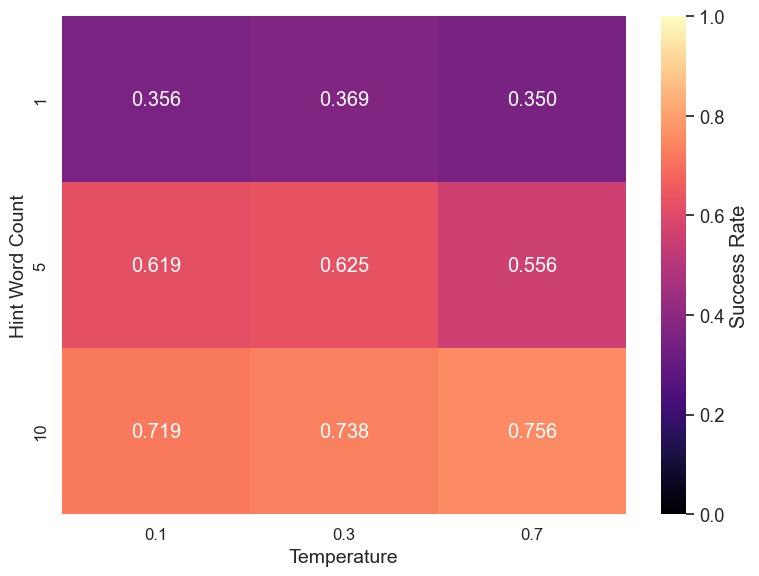


处理 Taboo Count = 5

DeepSeek-V3 成功率矩阵（taboo_count=5）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.425	0.300	0.388	
5				0.469	0.525	0.512	
10				0.512	0.550	0.500	
✓ 图4.32已保存


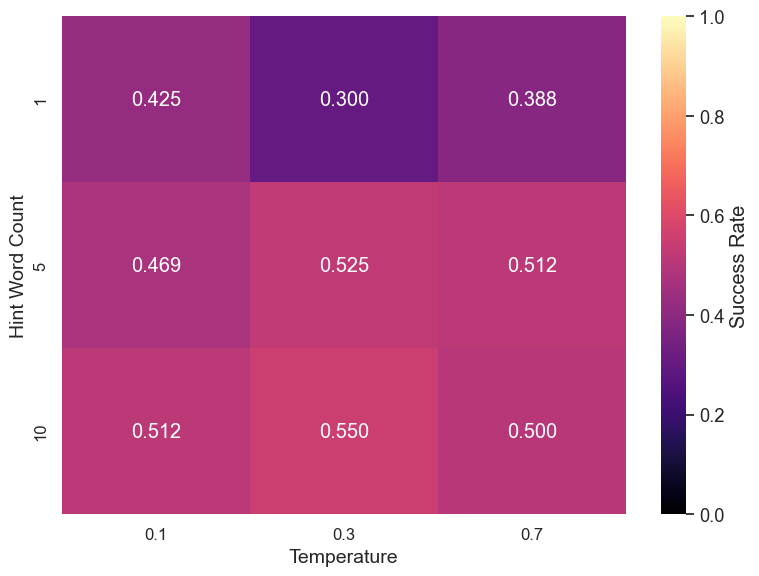


Gemini-2.5-Flash 成功率矩阵（taboo_count=5）:
hint_word_count ↓ \ temperature →	0.1	0.3	0.7	
1				0.325	0.350	0.306	
5				0.550	0.525	0.550	
10				0.669	0.669	0.656	
✓ 图4.33已保存


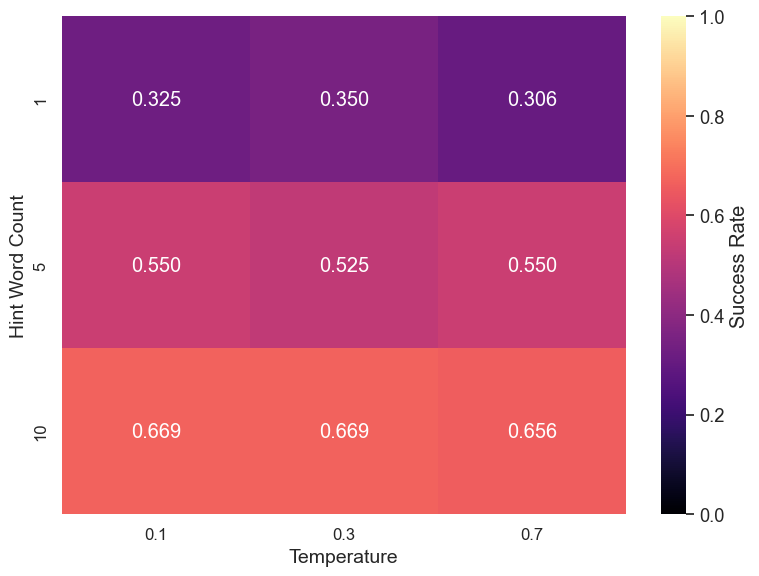

生成并排对比热力图...

处理 Taboo Count = 1 并排图
✓ 并排热力图（taboo_count=1）已保存


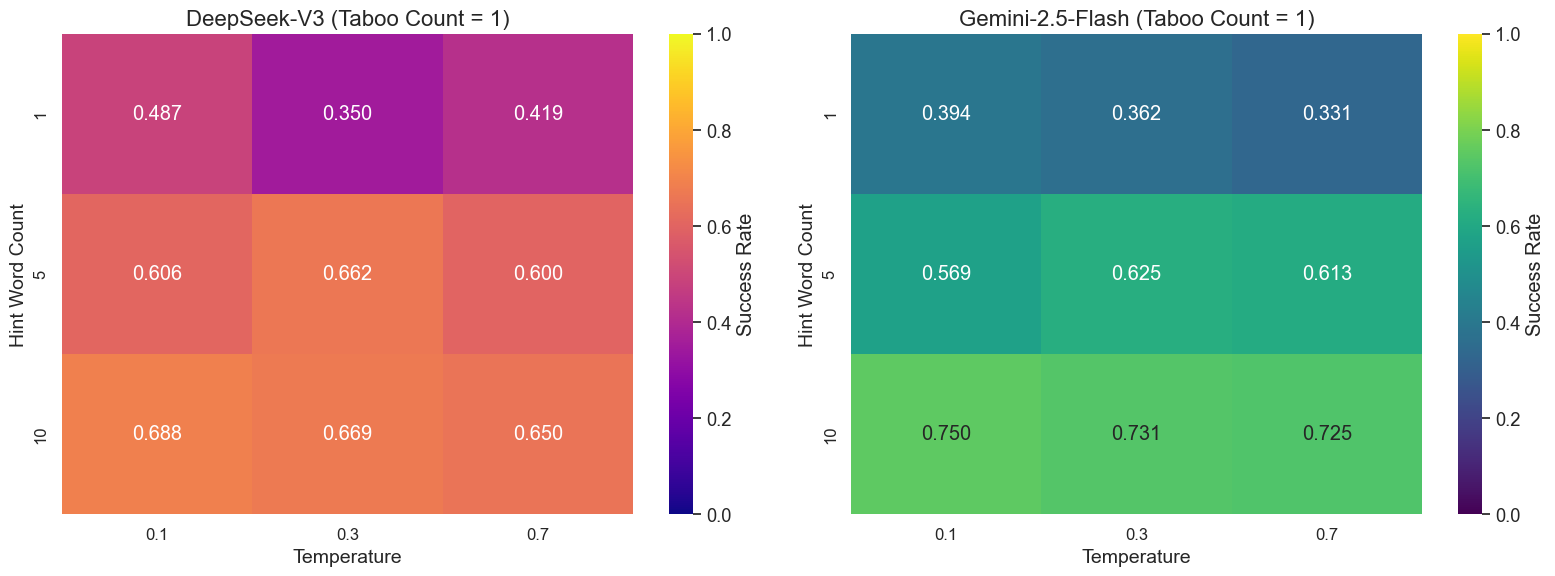


处理 Taboo Count = 3 并排图
✓ 并排热力图（taboo_count=3）已保存


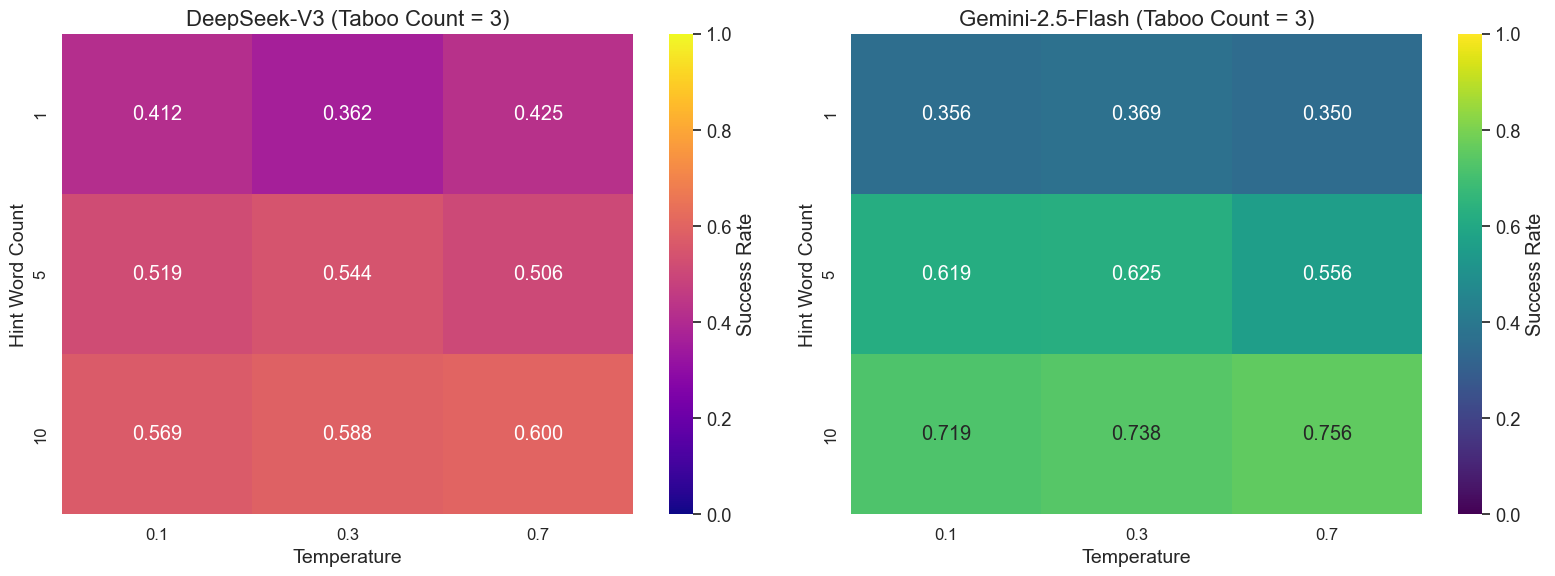


处理 Taboo Count = 5 并排图
✓ 并排热力图（taboo_count=5）已保存


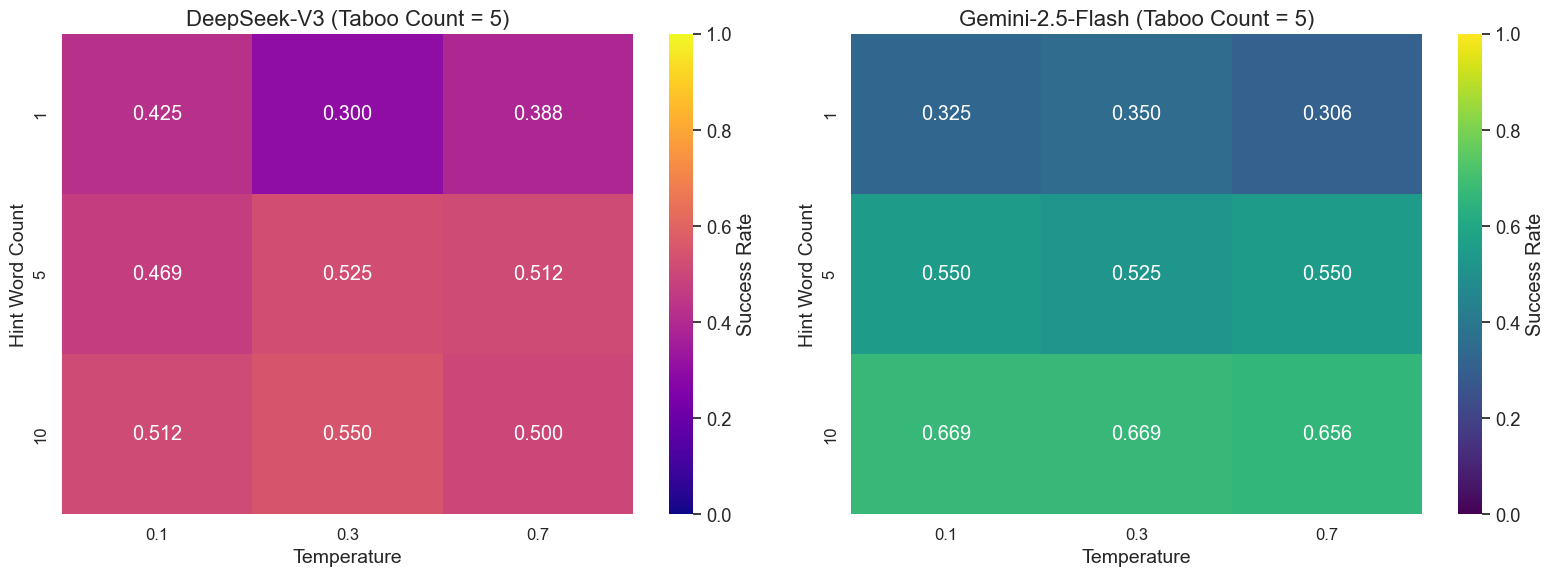


整体统计汇总
详细统计表:
     model_short  taboo_count  hint_word_count  temperature  total_count  success_count  success_rate
     DeepSeek-V3            1                1          0.1          160             78       0.48750
     DeepSeek-V3            1                1          0.3          160             56       0.35000
     DeepSeek-V3            1                1          0.7          160             67       0.41875
     DeepSeek-V3            1                5          0.1          160             97       0.60625
     DeepSeek-V3            1                5          0.3          160            106       0.66250
     DeepSeek-V3            1                5          0.7          160             96       0.60000
     DeepSeek-V3            1               10          0.1          160            110       0.68750
     DeepSeek-V3            1               10          0.3          160            107       0.66875
     DeepSeek-V3            1               10          0.7        

In [4]:
#!/usr/bin/env python3
"""
定量分析成功率热力图 - 生成图4.28-4.33
Quantitative Analysis Success Rate Heatmaps - Figures 4.28-4.33
"""

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# 设置绘图风格
sns.set_theme(style="white", font_scale=1.2)

def load_and_process_data():
    """加载并处理定量分析数据"""
    print("加载定量分析数据...")
    
    results_path = "results/quantitative_analysis_20250717_213821/quantitative_analysis_merged_20250717_213821.csv"
    df = pd.read_csv(results_path)
    
    print(f"原始数据行数: {len(df)}")
    
    # 过滤特定模型
    target_models = ['deepseek/deepseek-chat-v3-0324', 'google/gemini-2.5-flash']
    df_filtered = df[df['hinter_model'].isin(target_models)].copy()
    
    # 过滤特定温度
    target_temperatures = [0.1, 0.3, 0.7]
    df_filtered = df_filtered[df_filtered['temperature'].isin(target_temperatures)]
    
    # 过滤特定禁忌词数量
    target_taboo_counts = [1, 3, 5]
    df_filtered = df_filtered[df_filtered['taboo_count'].isin(target_taboo_counts)]
    
    # 过滤特定提示词长度
    target_hint_lengths = [1, 5, 10]
    df_filtered = df_filtered[df_filtered['hint_word_count'].isin(target_hint_lengths)]
    
    print(f"过滤后数据行数: {len(df_filtered)}")
    print(f"过滤后的模型: {df_filtered['hinter_model'].unique()}")
    print(f"过滤后的温度: {sorted(df_filtered['temperature'].unique())}")
    print(f"过滤后的taboo_count: {sorted(df_filtered['taboo_count'].unique())}")
    print(f"过滤后的hint_word_count: {sorted(df_filtered['hint_word_count'].unique())}")
    
    # 模型名称映射
    label_map = {
        "deepseek/deepseek-chat-v3-0324": "DeepSeek-V3",
        "google/gemini-2.5-flash": "Gemini-2.5-Flash",
    }
    
    df_filtered['model_short'] = df_filtered['hinter_model'].map(label_map)
    
    return df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths

def create_success_rate_matrix(data, model, target_hint_lengths, target_temperatures):
    """为指定模型创建成功率矩阵"""
    model_data = data[data['model_short'] == model]
    
    if len(model_data) == 0:
        # 创建空矩阵
        pivot_table = pd.DataFrame(index=target_hint_lengths, columns=target_temperatures)
        pivot_table = pivot_table.fillna(0)
        return pivot_table
    
    # 计算成功率
    success_rates = model_data.groupby(['hint_word_count', 'temperature']).agg({
        'success': ['count', 'sum']
    })
    success_rates.columns = ['total_count', 'success_count']
    success_rates['success_rate'] = success_rates['success_count'] / success_rates['total_count']
    success_rates = success_rates.reset_index()
    
    # 创建透视表
    pivot_table = success_rates.pivot(index='hint_word_count', columns='temperature', values='success_rate')
    
    # 确保所有组合都存在
    pivot_table = pivot_table.reindex(index=target_hint_lengths, columns=target_temperatures)
    
    return pivot_table

def create_individual_heatmaps(df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths):
    """创建单独的热力图（图4.28-4.33）"""
    print("生成单独热力图...")
    
    # 确保figures目录存在
    os.makedirs('figures', exist_ok=True)
    
    figure_numbers = {
        ('DeepSeek-V3', 1): '4.28',
        ('Gemini-2.5-Flash', 1): '4.29',
        ('DeepSeek-V3', 3): '4.30',
        ('Gemini-2.5-Flash', 3): '4.31',
        ('DeepSeek-V3', 5): '4.32',
        ('Gemini-2.5-Flash', 5): '4.33'
    }
    
    for taboo_count in target_taboo_counts:
        print(f"\n处理 Taboo Count = {taboo_count}")
        
        # 过滤当前taboo_count的数据
        taboo_data = df_filtered[df_filtered['taboo_count'] == taboo_count]
        
        if len(taboo_data) == 0:
            print(f"警告: taboo_count={taboo_count} 没有数据")
            continue
        
        for model in ['DeepSeek-V3', 'Gemini-2.5-Flash']:
            # 创建成功率矩阵
            pivot_table = create_success_rate_matrix(taboo_data, model, target_hint_lengths, target_temperatures)
            
            # 打印成功率表
            print(f"\n{model} 成功率矩阵（taboo_count={taboo_count}）:")
            print("hint_word_count ↓ \\ temperature →\t", end="")
            for temp in target_temperatures:
                print(f"{temp}\t", end="")
            print()
            
            for hint_len in target_hint_lengths:
                print(f"{hint_len}\t\t\t\t", end="")
                for temp in target_temperatures:
                    if hint_len in pivot_table.index and temp in pivot_table.columns:
                        rate = pivot_table.loc[hint_len, temp]
                        if pd.isna(rate):
                            print("N/A\t", end="")
                        else:
                            print(f"{rate:.3f}\t", end="")
                    else:
                        print("N/A\t", end="")
                print()
            
            # 创建单独热力图
            fig, ax = plt.subplots(figsize=(8, 6))
            
            # 使用magma色板保持一致性
            cmap = 'magma'
            
            # 绘制热力图
            sns.heatmap(pivot_table, 
                       annot=True, fmt='.3f', cmap=cmap,
                       cbar_kws={'label': 'Success Rate'},
                       ax=ax, vmin=0, vmax=1)
            
            # 设置标题和标签
            figure_num = figure_numbers.get((model, taboo_count), 'X.X')
            ax.set_xlabel('Temperature', fontsize=14)
            ax.set_ylabel('Hint Word Count', fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=12)
            
            plt.tight_layout()
            
            # 保存图表
            filename = f"figure_{figure_num.replace('.', '_')}_{model.lower().replace('-', '_')}_taboo_{taboo_count}_heatmap"
            plt.savefig(f'figures/{filename}.pdf', dpi=300, bbox_inches='tight')
            plt.savefig(f'figures/{filename}.png', dpi=300, bbox_inches='tight')
            print(f"✓ 图{figure_num}已保存")
            
            plt.show()

def create_combined_heatmaps(df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths):
    """创建并排热力图（用于对比）"""
    print("生成并排对比热力图...")
    
    for taboo_count in target_taboo_counts:
        print(f"\n处理 Taboo Count = {taboo_count} 并排图")
        
        # 过滤当前taboo_count的数据
        taboo_data = df_filtered[df_filtered['taboo_count'] == taboo_count]
        
        if len(taboo_data) == 0:
            continue
        
        # 为两个模型创建成功率矩阵
        deepseek_matrix = create_success_rate_matrix(taboo_data, 'DeepSeek-V3', target_hint_lengths, target_temperatures)
        gemini_matrix = create_success_rate_matrix(taboo_data, 'Gemini-2.5-Flash', target_hint_lengths, target_temperatures)
        
        # 创建并排热力图
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # DeepSeek热力图
        sns.heatmap(deepseek_matrix, 
                   annot=True, fmt='.3f', cmap='plasma', 
                   cbar_kws={'label': 'Success Rate'},
                   ax=ax1, vmin=0, vmax=1)
        ax1.set_title(f'DeepSeek-V3 (Taboo Count = {taboo_count})', fontsize=16)
        ax1.set_xlabel('Temperature', fontsize=14)
        ax1.set_ylabel('Hint Word Count', fontsize=14)
        ax1.tick_params(axis='both', which='major', labelsize=12)
        
        # Gemini热力图
        sns.heatmap(gemini_matrix, 
                   annot=True, fmt='.3f', cmap='viridis', 
                   cbar_kws={'label': 'Success Rate'},
                   ax=ax2, vmin=0, vmax=1)
        ax2.set_title(f'Gemini-2.5-Flash (Taboo Count = {taboo_count})', fontsize=16)
        ax2.set_xlabel('Temperature', fontsize=14)
        ax2.set_ylabel('Hint Word Count', fontsize=14)
        ax2.tick_params(axis='both', which='major', labelsize=12)
        
        plt.tight_layout()
        
        # 保存并排图
        filename = f"combined_heatmaps_taboo_count_{taboo_count}"
        plt.savefig(f'figures/{filename}.pdf', dpi=300, bbox_inches='tight')
        plt.savefig(f'figures/{filename}.png', dpi=300, bbox_inches='tight')
        print(f"✓ 并排热力图（taboo_count={taboo_count}）已保存")
        
        plt.show()

def generate_statistics_summary(df_filtered):
    """生成统计汇总"""
    print("\n" + "="*60)
    print("整体统计汇总")
    print("="*60)
    
    overall_stats = df_filtered.groupby(['model_short', 'taboo_count', 'hint_word_count', 'temperature']).agg({
        'success': ['count', 'sum']
    })
    overall_stats.columns = ['total_count', 'success_count']
    overall_stats['success_rate'] = overall_stats['success_count'] / overall_stats['total_count']
    overall_stats = overall_stats.reset_index()
    
    print("详细统计表:")
    print(overall_stats.to_string(index=False))
    
    # 按模型和禁忌词数量汇总
    print(f"\n按模型和禁忌词数量的平均成功率:")
    model_taboo_summary = overall_stats.groupby(['model_short', 'taboo_count'])['success_rate'].mean().reset_index()
    for _, row in model_taboo_summary.iterrows():
        print(f"  {row['model_short']} (taboo_count={row['taboo_count']}): {row['success_rate']:.3f}")

def main():
    print("开始定量分析成功率热力图生成...")
    
    try:
        # 1. 加载和处理数据
        df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths = load_and_process_data()
        
        # 2. 创建单独热力图（图4.28-4.33）
        create_individual_heatmaps(df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths)
        
        # 3. 创建并排对比热力图
        create_combined_heatmaps(df_filtered, target_temperatures, target_taboo_counts, target_hint_lengths)
        
        # 4. 生成统计汇总
        generate_statistics_summary(df_filtered)
        
        print(f"\n✅ 所有热力图已保存到 figures/ 目录")
        print("生成的图表:")
        print("  • 图4.28: DeepSeek-V3在1个禁忌词下的成功率热力图")
        print("  • 图4.29: Gemini-2.5-Flash在1个禁忌词下的成功率热力图")
        print("  • 图4.30: DeepSeek-V3在3个禁忌词下的成功率热力图")
        print("  • 图4.31: Gemini-2.5-Flash在3个禁忌词下的成功率热力图")
        print("  • 图4.32: DeepSeek-V3在5个禁忌词下的成功率热力图")
        print("  • 图4.33: Gemini-2.5-Flash在5个禁忌词下的成功率热力图")
        
    except Exception as e:
        print(f"❌ 分析过程中出现错误: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()
